### MEER SPATIOTEMPORAL

CUDA is available. Using GPU 'NVIDIA GeForce RTX 3050 4GB Laptop GPU'
Dataset shape: (1404469, 47)
Spatial features: ['latitude', 'longitude', 'accommodates', 'bedrooms']
Temporal features: ['DTF_day_of_week', 'DTF_month', 'DTF_is_weekend', 'DTF_season_sin', 'DTF_season_cos']
Amenity features: ['has_kitchen', 'has_wifi', 'has_smoke_alarm', 'has_essentials', 'has_hot_water', 'has_hair_dryer', 'has_washer', 'has_iron', 'has_dishes_and_silverware', 'has_bed_linens', 'has_hangers', 'has_cooking_basics', 'has_refrigerator', 'has_heating', 'has_tv', 'has_microwave', 'has_shampoo', 'has_hot_water_kettle', 'has_dedicated_workspace', 'has_cleaning_products']
Epoch [1/200], Train Loss: 1.0779, Val Loss: 1.0254
Epoch [11/200], Train Loss: 0.7047, Val Loss: 0.6433
Epoch [21/200], Train Loss: 0.5318, Val Loss: 0.4625
Epoch [31/200], Train Loss: 0.4441, Val Loss: 0.3722
Epoch [41/200], Train Loss: 0.3928, Val Loss: 0.3294
Epoch [51/200], Train Loss: 0.3628, Val Loss: 0.3016
Epoch [61/200], Train Los

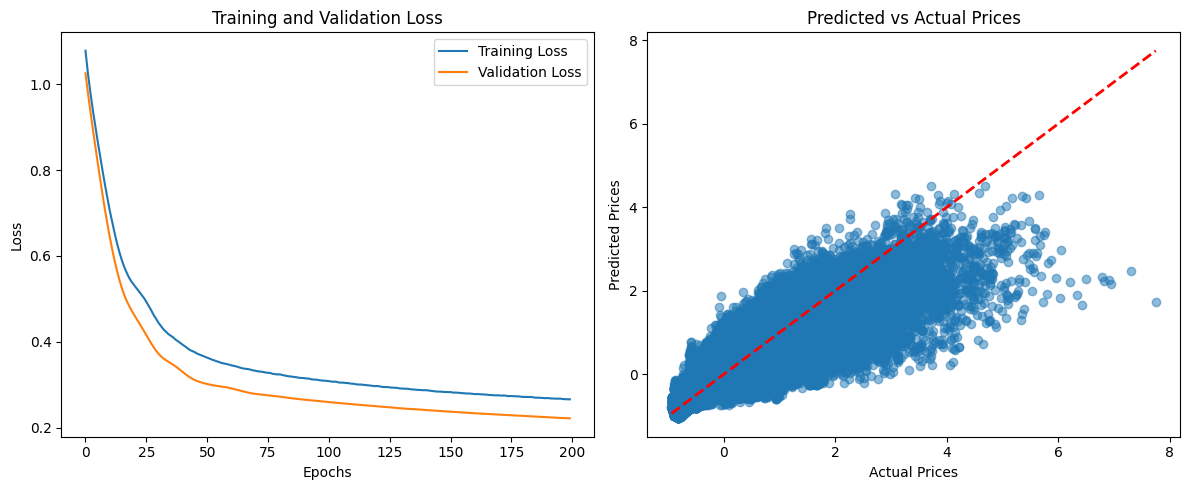


Model Performance Metrics:
Root Mean Squared Error (RMSE): 0.3475
Mean Absolute Error (MAE): 0.2267
Mean Absolute Percentage Error (MAPE): 2.6802
R-squared (R²): 0.7797


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    mean_squared_error, 
    mean_absolute_error, 
    mean_absolute_percentage_error, 
    r2_score
)
import torch_geometric
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

def get_device():
    """
    Select available device (GPU or CPU)
    """
    if torch.cuda.is_available():
        print(f"CUDA is available. Using GPU '{torch.cuda.get_device_name(0)}'")
        return torch.device("cuda")
    else:
        print("No CUDA available. Using CPU.")
        return torch.device("cpu")

class SpatioTemporalNetwork(nn.Module):
    def __init__(self, 
                 spatial_features_dim,
                 temporal_features_dim,
                 amenity_features_dim,
                 hidden_dim=64):
        super(SpatioTemporalNetwork, self).__init__()
        
        # Temporal processing
        self.temporal_layer = nn.Sequential(
            nn.Linear(temporal_features_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        
        # Spatial processing
        self.spatial_layer = nn.Sequential(
            nn.Linear(spatial_features_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        
        # Amenity processing
        self.amenity_layer = nn.Sequential(
            nn.Linear(amenity_features_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        
        # Combination and prediction layers
        self.prediction_layer = nn.Sequential(
            nn.Linear(hidden_dim * 3, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, 1)
        )
    
    def forward(self, data):
        # Unpack the PyG data object
        x, temporal_x, amenity_x = data.x, data.temporal_x, data.amenity_x
        
        # Process spatial features
        spatial_features = self.spatial_layer(x)
        
        # Process temporal features
        temporal_features = self.temporal_layer(temporal_x)
        
        # Process amenity features
        amenity_features = self.amenity_layer(amenity_x)
        
        # Combine features
        combined_features = torch.cat([
            spatial_features, 
            temporal_features, 
            amenity_features
        ], dim=1)
        
        # Final prediction
        price_prediction = self.prediction_layer(combined_features)
        return price_prediction

def prepare_spatiotemporal_data(file_path, device, test_size=0.2, random_state=42):
    # Load dataset
    df = pd.read_csv(file_path)
    
    # Feature selection
    spatial_features = ['latitude', 'longitude', 'accommodates', 'bedrooms']
    temporal_features = [
        'DTF_day_of_week', 'DTF_month', 'DTF_is_weekend', 
        'DTF_season_sin', 'DTF_season_cos'
    ]
    amenity_features = [
        col for col in df.columns 
        if col.startswith('has_') and col not in ['has_availability']
    ]
    
    # Print dataset info for debugging
    print("Dataset shape:", df.shape)
    print("Spatial features:", spatial_features)
    print("Temporal features:", temporal_features)
    print("Amenity features:", amenity_features)
    
    # Prepare features
    X_spatial = df[spatial_features].values
    X_temporal = df[temporal_features].values
    X_amenity = df[amenity_features].values
    y = df['simulated_price'].values
    
    # Scaling
    spatial_scaler = StandardScaler()
    temporal_scaler = StandardScaler()
    target_scaler = StandardScaler()
    
    X_spatial_scaled = spatial_scaler.fit_transform(X_spatial)
    X_temporal_scaled = temporal_scaler.fit_transform(X_temporal)
    y_scaled = target_scaler.fit_transform(y.reshape(-1, 1)).flatten()
    
    # Split data
    (X_spatial_train, X_spatial_test, 
     X_temporal_train, X_temporal_test, 
     X_amenity_train, X_amenity_test, 
     y_train, y_test) = train_test_split(
        X_spatial_scaled, X_temporal_scaled, X_amenity, y_scaled, 
        test_size=test_size, random_state=random_state
    )
    
    # Create PyG data objects
    def create_pyg_data(X_spatial, X_temporal, X_amenity, y):
        # Convert to tensors
        x = torch.FloatTensor(X_spatial)
        temporal_x = torch.FloatTensor(X_temporal)
        amenity_x = torch.FloatTensor(X_amenity)
        y = torch.FloatTensor(y.reshape(-1, 1))
        
        # Create PyG data object
        data = Data(
            x=x, 
            temporal_x=temporal_x, 
            amenity_x=amenity_x, 
            y=y
        )
        return data
    
    # Create training and testing datasets
    train_data = create_pyg_data(X_spatial_train, X_temporal_train, X_amenity_train, y_train)
    test_data = create_pyg_data(X_spatial_test, X_temporal_test, X_amenity_test, y_test)
    
    # Create data loaders
    train_loader = DataLoader([train_data], batch_size=1, shuffle=False)
    test_loader = DataLoader([test_data], batch_size=1, shuffle=False)
    
    return train_loader, test_loader, target_scaler

def train_and_evaluate_model(model, 
                              train_loader, 
                              test_loader, 
                              target_scaler,
                              device,
                              epochs=200, 
                              learning_rate=0.001):
    # Move model to device
    model = model.to(device)
    
    # Optimizer and Loss
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # Training and validation lists
    train_losses = []
    val_losses = []
    
    # Training Loop
    for epoch in range(epochs):
        # Training Mode
        model.train()
        epoch_train_loss = 0
        
        for batch in train_loader:
            batch = batch.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            y_pred = model(batch)
            loss = criterion(y_pred, batch.y)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            epoch_train_loss += loss.item()
        
        # Average training loss
        avg_train_loss = epoch_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        # Validation Mode
        model.eval()
        epoch_val_loss = 0
        
        with torch.no_grad():
            for batch in test_loader:
                batch = batch.to(device)
                val_pred = model(batch)
                val_loss = criterion(val_pred, batch.y)
                epoch_val_loss += val_loss.item()
        
        # Average validation loss
        avg_val_loss = epoch_val_loss / len(test_loader)
        val_losses.append(avg_val_loss)
        
        # Print Progress
        if epoch % 10 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')
    
    # Final Evaluation
    model.eval()
    with torch.no_grad():
        # Collect predictions and true values
        all_preds = []
        all_true = []
        
        for batch in test_loader:
            batch = batch.to(device)
            y_pred = model(batch)
            
            # Move to CPU for numpy conversion
            all_preds.append(y_pred.cpu().numpy())
            all_true.append(batch.y.cpu().numpy())
        
        # Combine predictions
        test_pred_original = target_scaler.inverse_transform(np.concatenate(all_preds))
        y_test_original = target_scaler.inverse_transform(np.concatenate(all_true))
        
        # Calculate Metrics
        rmse = np.sqrt(mean_squared_error(y_test_original, test_pred_original))
        mae = mean_absolute_error(y_test_original, test_pred_original)
        mape = mean_absolute_percentage_error(y_test_original, test_pred_original)
        r2 = r2_score(y_test_original, test_pred_original)
        
        # Visualization
        plt.figure(figsize=(12, 5))
        
        # Training and Validation Loss
        plt.subplot(1, 2, 1)
        plt.plot(train_losses, label='Training Loss')
        plt.plot(val_losses, label='Validation Loss')
        plt.title('Training and Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        
        # Predicted vs Actual
        plt.subplot(1, 2, 2)
        plt.scatter(y_test_original, test_pred_original, alpha=0.5)
        plt.plot([y_test_original.min(), y_test_original.max()], 
                 [y_test_original.min(), y_test_original.max()], 
                 'r--', lw=2)
        plt.title('Predicted vs Actual Prices')
        plt.xlabel('Actual Prices')
        plt.ylabel('Predicted Prices')
        
        plt.tight_layout()
        plt.show()
        
        # Print Metrics
        print("\nModel Performance Metrics:")
        print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
        print(f"Mean Absolute Error (MAE): {mae:.4f}")
        print(f"Mean Absolute Percentage Error (MAPE): {mape:.4f}")
        print(f"R-squared (R²): {r2:.4f}")
    
    return model

def main():
    # Select device
    device = get_device()
    
    # File path
    file_path = r"C:\Users\matth\OneDrive\Documents\KU Leuven\Thesis\De Ultieme Data\top_price_changers_subset\temporal_features_combined.csv"
    
    # Prepare data
    train_loader, test_loader, target_scaler = prepare_spatiotemporal_data(file_path, device)
    
    # Initialize model
    model = SpatioTemporalNetwork(
        spatial_features_dim=4,  # latitude, longitude, accommodates, bedrooms
        temporal_features_dim=5,  # day of week, month, is_weekend, season_sin, season_cos
        amenity_features_dim=len([col for col in pd.read_csv(file_path).columns if col.startswith('has_') and col != 'has_availability'])
    )
    
    # Train and evaluate model
    trained_model = train_and_evaluate_model(
        model, 
        train_loader,
        test_loader,
        target_scaler,
        device
    )

if __name__ == '__main__':
    main()

### correct

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    mean_squared_error, 
    mean_absolute_error, 
    mean_absolute_percentage_error, 
    r2_score
)
import torch_geometric
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from datetime import timedelta
import os

import warnings
warnings.filterwarnings('ignore')  # This will suppress all warnings

def get_device():
    """
    Select available device (GPU or CPU)
    """
    if torch.cuda.is_available():
        print(f"CUDA is available. Using GPU '{torch.cuda.get_device_name(0)}'")
        return torch.device("cuda")
    else:
        print("No CUDA available. Using CPU.")
        return torch.device("cpu")

class SpatioTemporalNetwork(nn.Module):
    def __init__(self, 
                 spatial_features_dim,
                 temporal_features_dim,
                 amenity_features_dim,
                 hidden_dim=64):
        super(SpatioTemporalNetwork, self).__init__()
        
        # Temporal processing
        self.temporal_layer = nn.Sequential(
            nn.Linear(temporal_features_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        
        # Spatial processing
        self.spatial_layer = nn.Sequential(
            nn.Linear(spatial_features_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        
        # Amenity processing
        self.amenity_layer = nn.Sequential(
            nn.Linear(amenity_features_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        
        # Combination and prediction layers
        self.prediction_layer = nn.Sequential(
            nn.Linear(hidden_dim * 3, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, 1)
        )
    
    def forward(self, data):
        # Unpack the PyG data object
        x, temporal_x, amenity_x = data.x, data.temporal_x, data.amenity_x
        
        # Process spatial features
        spatial_features = self.spatial_layer(x)
        
        # Process temporal features
        temporal_features = self.temporal_layer(temporal_x)
        
        # Process amenity features
        amenity_features = self.amenity_layer(amenity_x)
        
        # Combine features
        combined_features = torch.cat([
            spatial_features, 
            temporal_features, 
            amenity_features
        ], dim=1)
        
        # Final prediction
        price_prediction = self.prediction_layer(combined_features)
        return price_prediction

def train_model(model, train_data, device, epochs=100, learning_rate=0.001):
    """
    Train model for a single fold
    """
    model = model.to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    train_losses = []
    
    # Training loop
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        
        # Forward pass
        y_pred = model(train_data)
        loss = criterion(y_pred, train_data.y)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        train_losses.append(loss.item())
        
        # Print progress periodically
        if epoch % 10 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')
    
    return model, train_losses

def evaluate_model(model, val_data, target_scaler, original_prices=None):
    """
    Evaluate model on validation data
    """
    model.eval()
    with torch.no_grad():
        # Get predictions
        predictions = model(val_data)
        
        # Convert to numpy for easier processing
        predictions_np = predictions.cpu().numpy()
        true_values_np = val_data.y.cpu().numpy()
        
        # Inverse transform to original scale
        predictions_original = target_scaler.inverse_transform(predictions_np)
        true_values_original = target_scaler.inverse_transform(true_values_np)
        
        # Calculate metrics on normalized scale
        mse = mean_squared_error(true_values_np, predictions_np)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(true_values_np, predictions_np)
        
        # Calculate metrics on original scale
        rmse_original = np.sqrt(mean_squared_error(true_values_original, predictions_original))
        mae_original = mean_absolute_error(true_values_original, predictions_original)
        
        # If original prices are provided, calculate metrics against those
        if original_prices is not None:
            original_prices_array = np.array(original_prices).reshape(-1, 1)
            rmse_vs_original = np.sqrt(mean_squared_error(original_prices_array, predictions_original))
            mae_vs_original = mean_absolute_error(original_prices_array, predictions_original)
            mape_vs_original = mean_absolute_percentage_error(original_prices_array, predictions_original)
            r2_vs_original = r2_score(original_prices_array, predictions_original)
        else:
            rmse_vs_original = None
            mae_vs_original = None
            mape_vs_original = None
            r2_vs_original = None
        
        metrics = {
            'mse': mse,
            'rmse': rmse,
            'mae': mae,
            'rmse_original': rmse_original,
            'mae_original': mae_original,
            'rmse_vs_actual': rmse_vs_original,
            'mae_vs_actual': mae_vs_original,
            'mape_vs_actual': mape_vs_original,
            'r2_vs_actual': r2_vs_original,
            'predictions': predictions_original,
            'true_values': true_values_original
        }
        
        return metrics

def run_time_based_cv(data_path, train_ids_path, test_ids_path, n_folds=5, epochs=100, learning_rate=0.001, output_path=None):
    """
    Run time-based cross-validation with sequential validation weeks
    """
    print(f"Running neural network with time-based CV using {n_folds} consecutive validation weeks")
    
    # Select device
    device = get_device()
    
    # Load train and test IDs
    try:
        with open(train_ids_path, 'r') as f:
            train_ids = [int(line.strip()) for line in f.readlines()]
        print(f"Loaded {len(train_ids)} training listing IDs")
        
        with open(test_ids_path, 'r') as f:
            test_ids = [int(line.strip()) for line in f.readlines()]
        print(f"Loaded {len(test_ids)} test listing IDs")
    except Exception as e:
        raise ValueError(f"Error loading train/test IDs: {e}")
    
    # Load data
    print("Loading data...")
    df = pd.read_csv(data_path)
    
    # Convert date column to datetime
    df['date'] = pd.to_datetime(df['date'])
    
    # Sort by date
    df = df.sort_values(['listing_id', 'date'])
    
    # Get the min and max dates in the dataset
    min_date = df['date'].min()
    max_date = df['date'].max()
    
    print(f"Data spans from {min_date.date()} to {max_date.date()}")
    
    # Calculate total dataset duration
    total_days = (max_date - min_date).days + 1
    weeks_available = total_days // 7
    
    print(f"Total duration: {total_days} days ({weeks_available} weeks)")
    
    # Create consecutive time-based folds using the last n_folds weeks
    folds = []
    
    for i in range(n_folds):
        # Calculate weeks from the end (0 = last week, 1 = second last week, etc.)
        weeks_from_end = n_folds - 1 - i
        
        # Calculate validation start and end dates
        val_start = max_date - timedelta(days=(weeks_from_end + 1) * 7 - 1)
        val_end = max_date - timedelta(days=weeks_from_end * 7)
        
        # Ensure val_start is not before the first day of data
        if val_start < min_date:
            val_start = min_date
        
        # Training period ends just before validation
        train_end = val_start - timedelta(days=1)
        train_start = min_date
        
        folds.append({
            'fold': i + 1,
            'train_start': train_start,
            'train_end': train_end,
            'val_start': val_start,
            'val_end': val_end
        })
    
    print("Time-based CV folds with consecutive validation weeks:")
    for fold_info in folds:
        print(f"Fold {fold_info['fold']}: "
              f"Train {fold_info['train_start'].date()} to {fold_info['train_end'].date()}, "
              f"Validation {fold_info['val_start'].date()} to {fold_info['val_end'].date()}")
    
    # Define features
    spatial_features = ['latitude', 'longitude', 'accommodates', 'bedrooms']
    temporal_features = [
        'DTF_day_of_week', 'DTF_month', 'DTF_is_weekend', 
        'DTF_season_sin', 'DTF_season_cos'
    ]
    amenity_features = [
        col for col in df.columns 
        if col.startswith('has_') and col not in ['has_availability']
    ]
    
    # Initialize scalers using ALL historical data to simulate production scenario
    # In a real-world scenario, you'd only use data available up to the current point in time
    initial_data = df[(df['date'] <= folds[0]['train_end']) & (df['listing_id'].isin(train_ids))].copy()
    
    print("Fitting scalers on initial training data...")
    spatial_scaler = StandardScaler().fit(initial_data[spatial_features])
    temporal_scaler = StandardScaler().fit(initial_data[temporal_features])
    target_scaler = StandardScaler().fit(initial_data['simulated_price'].values.reshape(-1, 1))
    
    # Count amenity features
    amenity_features_count = len(amenity_features)
    
    # Initialize model parameters
    model_params = {
        'spatial_features_dim': len(spatial_features),
        'temporal_features_dim': len(temporal_features),
        'amenity_features_dim': amenity_features_count,
        'hidden_dim': 64
    }
    
    # Store results
    all_fold_results = []
    fold_metrics = []
    
    # Modified prepare_data_for_time_window function for this context
    def prepare_data_for_fold(fold_info, fixed_scalers=True):
        """Prepare data for a specific fold using the pre-fitted scalers"""
        train_start = fold_info['train_start']
        train_end = fold_info['train_end']
        val_start = fold_info['val_start']
        val_end = fold_info['val_end']
        
        # Filter by date ranges and listing IDs
        train_data = df[(df['date'] >= train_start) & 
                        (df['date'] <= train_end) & 
                        (df['listing_id'].isin(train_ids))].copy()
        
        val_data = df[(df['date'] >= val_start) & 
                      (df['date'] <= val_end) & 
                      (df['listing_id'].isin(test_ids))].copy()
        
        if len(train_data) == 0 or len(val_data) == 0:
            print(f"Warning: Empty dataset for time window {train_start} to {val_end}")
            return None, None, None
        
        # Prepare features
        X_train_spatial = train_data[spatial_features].values
        X_train_temporal = train_data[temporal_features].values
        X_train_amenity = train_data[amenity_features].values
        y_train = train_data['price'].values
        
        X_val_spatial = val_data[spatial_features].values
        X_val_temporal = val_data[temporal_features].values
        X_val_amenity = val_data[amenity_features].values
        y_val = val_data['simulated_price'].values
        
        # If we want to use fold-specific scalers (for comparison)
        fold_specific_scalers = {}
        if not fixed_scalers:
            fold_specific_scalers['spatial'] = StandardScaler().fit(X_train_spatial)
            fold_specific_scalers['temporal'] = StandardScaler().fit(X_train_temporal)
            fold_specific_scalers['target'] = StandardScaler().fit(y_train.reshape(-1, 1))
            
            # Use fold-specific scalers
            X_train_spatial_scaled = fold_specific_scalers['spatial'].transform(X_train_spatial)
            X_train_temporal_scaled = fold_specific_scalers['temporal'].transform(X_train_temporal)
            y_train_scaled = fold_specific_scalers['target'].transform(y_train.reshape(-1, 1)).flatten()
            
            X_val_spatial_scaled = fold_specific_scalers['spatial'].transform(X_val_spatial)
            X_val_temporal_scaled = fold_specific_scalers['temporal'].transform(X_val_temporal)
            y_val_scaled = fold_specific_scalers['target'].transform(y_val.reshape(-1, 1)).flatten()
            
            current_target_scaler = fold_specific_scalers['target']
        else:
            # Use the fixed pre-fitted scalers (correct approach for time-based CV)
            X_train_spatial_scaled = spatial_scaler.transform(X_train_spatial)
            X_train_temporal_scaled = temporal_scaler.transform(X_train_temporal)
            y_train_scaled = target_scaler.transform(y_train.reshape(-1, 1)).flatten()
            
            X_val_spatial_scaled = spatial_scaler.transform(X_val_spatial)
            X_val_temporal_scaled = temporal_scaler.transform(X_val_temporal)
            y_val_scaled = target_scaler.transform(y_val.reshape(-1, 1)).flatten()
            
            current_target_scaler = target_scaler
        
        # Create PyG data objects
        def create_pyg_data(X_spatial, X_temporal, X_amenity, y):
            # Convert to tensors
            x = torch.FloatTensor(X_spatial).to(device)
            temporal_x = torch.FloatTensor(X_temporal).to(device)
            amenity_x = torch.FloatTensor(X_amenity).to(device)
            y = torch.FloatTensor(y.reshape(-1, 1)).to(device)
            
            # Create PyG data object
            data = Data(
                x=x, 
                temporal_x=temporal_x, 
                amenity_x=amenity_x, 
                y=y
            )
            return data
        
        # Create data objects
        train_data_obj = create_pyg_data(X_train_spatial_scaled, X_train_temporal_scaled, X_train_amenity, y_train_scaled)
        val_data_obj = create_pyg_data(X_val_spatial_scaled, X_val_temporal_scaled, X_val_amenity, y_val_scaled)
        
        return train_data_obj, val_data_obj, current_target_scaler
    
    # Run CV
    for fold_info in folds:
        fold = fold_info['fold']
        
        print(f"\nProcessing fold {fold} "
              f"(Train: {fold_info['train_start'].date()} to {fold_info['train_end'].date()}, "
              f"Val: {fold_info['val_start'].date()} to {fold_info['val_end'].date()})...")
        
        # Prepare data for this fold using the fixed scalers (no leakage)
        train_data, val_data, current_target_scaler = prepare_data_for_fold(fold_info, fixed_scalers=True)
        
        if train_data is None or val_data is None:
            print(f"Warning: Skipping fold {fold} due to insufficient data")
            continue
        
        # Print dataset sizes
        print(f"Training data: {len(train_data.y)} samples")
        print(f"Validation data: {len(val_data.y)} samples")
        
        # Initialize new model for this fold
        model = SpatioTemporalNetwork(**model_params)
        
        # Train model
        print(f"Training model for fold {fold}...")
        trained_model, train_losses = train_model(
            model, train_data, device, epochs=epochs, learning_rate=learning_rate
        )
        
        # Evaluate model
        print(f"Evaluating model for fold {fold}...")
        # Get actual prices for the validation set
        val_filter = (df['date'] >= fold_info['val_start']) & (df['date'] <= fold_info['val_end']) & (df['listing_id'].isin(test_ids))
        actual_prices = df.loc[val_filter, 'price'].values
        
        metrics = evaluate_model(trained_model, val_data, current_target_scaler, actual_prices)
        
        # Add fold info to metrics
        metrics['fold'] = fold
        metrics['train_start'] = fold_info['train_start']
        metrics['train_end'] = fold_info['train_end']
        metrics['val_start'] = fold_info['val_start']
        metrics['val_end'] = fold_info['val_end']
        metrics['train_samples'] = len(train_data.y)
        metrics['val_samples'] = len(val_data.y)
        metrics['final_train_loss'] = train_losses[-1]
        
        # Store predictions with dates and listing IDs for later analysis
        val_results = df.loc[val_filter, ['date', 'listing_id', 'price', 'simulated_price']].copy()
        val_results['predicted_price'] = metrics['predictions'].flatten()
        val_results['fold'] = fold
        
        # Calculate errors
        val_results['error'] = val_results['price'] - val_results['predicted_price']
        val_results['abs_error'] = np.abs(val_results['error'])
        val_results['pct_error'] = (np.abs(val_results['error']) / np.abs(val_results['price'] + 1e-8)) * 100
        
        # Add to overall results
        all_fold_results.append(val_results)
        fold_metrics.append(metrics)
        
        # Print metrics
        print(f"Fold {fold} Metrics:")
        print(f"  RMSE (vs simulated): {metrics['rmse_original']:.4f}")
        print(f"  MAE (vs simulated): {metrics['mae_original']:.4f}")
        print(f"  RMSE (vs actual): {metrics['rmse_vs_actual']:.4f}")
        print(f"  MAE (vs actual): {metrics['mae_vs_actual']:.4f}")
        print(f"  MAPE (vs actual): {metrics['mape_vs_actual']:.4f}")
        print(f"  R² (vs actual): {metrics['r2_vs_actual']:.4f}")
    
    # Combine all results
    if not all_fold_results:
        print("Warning: No results to process. Check if data and folds are valid.")
        return None
    
    all_results = pd.concat(all_fold_results, ignore_index=True)
    
    # Calculate overall metrics
    y_true = all_results['price'].values
    y_pred = all_results['predicted_price'].values
    
    overall_metrics = {
        'rmse': np.sqrt(mean_squared_error(y_true, y_pred)),
        'mae': mean_absolute_error(y_true, y_pred),
        'mape': mean_absolute_percentage_error(y_true, y_pred) * 100,
        'r2': r2_score(y_true, y_pred)
    }
    
    print("\nOverall Metrics:")
    print(f"RMSE: {overall_metrics['rmse']:.4f}")
    print(f"MAE: {overall_metrics['mae']:.4f}")
    print(f"MAPE: {overall_metrics['mape']:.2f}%")
    print(f"R²: {overall_metrics['r2']:.4f}")
    
    # Create fold metrics dataframe
    fold_metrics_df = pd.DataFrame([
        {
            'fold': m['fold'],
            'rmse': m['rmse_vs_actual'],
            'mae': m['mae_vs_actual'],
            'mape': m['mape_vs_actual'] * 100,
            'r2': m['r2_vs_actual'],
            'train_samples': m['train_samples'],
            'val_samples': m['val_samples'],
            'final_train_loss': m['final_train_loss']
        } for m in fold_metrics
    ])
    
    print("\nPerformance by Fold:")
    print(fold_metrics_df)
    
    # Calculate daily metrics
    all_results['date_only'] = all_results['date'].dt.date
    daily_metrics = []
    
    for date in all_results['date_only'].unique():
        date_data = all_results[all_results['date_only'] == date]
        
        y_true_day = date_data['price'].values
        y_pred_day = date_data['predicted_price'].values
        
        daily_metrics.append({
            'date': date,
            'rmse': np.sqrt(mean_squared_error(y_true_day, y_pred_day)),
            'mae': mean_absolute_error(y_true_day, y_pred_day),
            'mape': mean_absolute_percentage_error(y_true_day, y_pred_day) * 100,
            'r2': r2_score(y_true_day, y_pred_day) if len(set(y_true_day)) > 1 else np.nan,
            'n_samples': len(y_true_day),
            'fold': date_data['fold'].iloc[0]  # Assume all records for a day are in the same fold
        })
    
    daily_metrics_df = pd.DataFrame(daily_metrics)
    
    # Save results if output path provided
    if output_path:
        os.makedirs(os.path.dirname(os.path.abspath(output_path)), exist_ok=True)
        
        # Save prediction results
        all_results.to_csv(output_path, index=False)
        print(f"Results saved to {output_path}")
        
        # Save fold metrics
        metrics_path = output_path.replace('.csv', '_fold_metrics.csv')
        fold_metrics_df.to_csv(metrics_path, index=False)
        print(f"Fold metrics saved to {metrics_path}")
        
        # Save daily metrics
        daily_metrics_path = output_path.replace('.csv', '_daily_metrics.csv')
        daily_metrics_df.to_csv(daily_metrics_path, index=False)
        print(f"Daily metrics saved to {daily_metrics_path}")
    
    # Create evaluation results dictionary (similar to baseline for compatibility)
    evaluation_results = {
        'overall_metrics': overall_metrics,
        'fold_metrics': fold_metrics_df,
        'daily_metrics': daily_metrics_df,
        'all_results': all_results
    }
    
    return evaluation_results

def plot_fold_performance(results):
    """
    Plot performance metrics across different folds
    """
    fold_metrics = results['fold_metrics']
    
    metrics_to_plot = ['rmse', 'mae', 'mape']
    fig, axes = plt.subplots(len(metrics_to_plot), 1, figsize=(10, 4 * len(metrics_to_plot)))
    
    for i, metric in enumerate(metrics_to_plot):
        ax = axes[i] if len(metrics_to_plot) > 1 else axes
        plt.sca(ax)
        plt.bar(fold_metrics['fold'], fold_metrics[metric])
        plt.title(f'Fold Performance - {metric.upper()}')
        plt.xlabel('Fold')
        plt.ylabel(metric.upper())
        
        # Add value labels on top of each bar
        for j, (x, y) in enumerate(zip(fold_metrics['fold'], fold_metrics[metric])):
            plt.text(x, y + (fold_metrics[metric].max() * 0.01), f'{y:.2f}', 
                    ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.show()

def plot_time_series_metrics(results):
    """
    Plot metrics over time
    """
    daily_metrics = results['daily_metrics']
    daily_metrics['date'] = pd.to_datetime(daily_metrics['date'])
    daily_metrics = daily_metrics.sort_values('date')
    
    metrics_to_plot = ['rmse', 'mae']
    fig, axes = plt.subplots(len(metrics_to_plot), 1, figsize=(12, 8))
    
    for i, metric in enumerate(metrics_to_plot):
        ax = axes[i] if len(metrics_to_plot) > 1 else axes
        
        # Create colormap based on fold
        n_folds = len(daily_metrics['fold'].unique())
        cmap = plt.cm.get_cmap('viridis', n_folds)
        
        for fold, fold_data in daily_metrics.groupby('fold'):
            color = cmap(int(fold)-1)
            ax.plot(
                fold_data['date'], 
                fold_data[metric], 
                marker='o', 
                linestyle='-', 
                label=f'Fold {fold}',
                color=color
            )
        
        ax.set_title(f'Daily {metric.upper()} Over Time')
        ax.set_xlabel('Date')
        ax.set_ylabel(metric.upper())
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # Format x-axis date ticks
        ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d'))
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
    
    plt.tight_layout()
    plt.show()

def plot_actual_vs_predicted(results):
    """
    Plot actual vs predicted values
    """
    all_results = results['all_results']
    
    plt.figure(figsize=(10, 8))
    
    # Sample 5000 points if there are too many
    if len(all_results) > 5000:
        sample = all_results.sample(5000, random_state=42)
    else:
        sample = all_results
    
    # Create scatterplot
    plt.scatter(sample['price'], sample['predicted_price'], alpha=0.5)
    
    # Add perfect prediction line
    min_val = min(sample['price'].min(), sample['predicted_price'].min())
    max_val = max(sample['price'].max(), sample['predicted_price'].max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--')
    
    # Add regression line
    from scipy import stats
    slope, intercept, r_value, p_value, std_err = stats.linregress(
        sample['price'], sample['predicted_price']
    )
    plt.plot(
        [min_val, max_val], 
        [slope * min_val + intercept, slope * max_val + intercept], 
        'b-'
    )
    
    plt.title('Actual vs Predicted Values')
    plt.xlabel('Actual Price')
    plt.ylabel('Predicted Price')
    
    # Add R² value
    r2 = results['overall_metrics']['r2']
    plt.annotate(f'R² = {r2:.4f}', xy=(0.05, 0.95), xycoords='axes fraction',
                 bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.8))
    
    plt.tight_layout()
    plt.show()

def run_nn_analysis(data_path, train_ids_path, test_ids_path, n_folds=5, epochs=50, learning_rate=0.001, output_path='results/nn_results.csv'):
    """
    Run a complete neural network analysis with time-based CV
    """
    # Create results directory
    os.makedirs('results', exist_ok=True)
    
    # Run the cross-validation
    results = run_time_based_cv(
        data_path=data_path,
        train_ids_path=train_ids_path,
        test_ids_path=test_ids_path,
        n_folds=n_folds,
        epochs=epochs,
        learning_rate=learning_rate,
        output_path=output_path
    )
    
    if results is None:
        print("Analysis failed. Check error messages above.")
        return None
    
    # Print summary
    print("\nNeural Network Model Performance Summary:")
    print("========================================")
    print(f"Overall RMSE: {results['overall_metrics']['rmse']:.4f}")
    print(f"Overall MAE: {results['overall_metrics']['mae']:.4f}")
    print(f"Overall MAPE: {results['overall_metrics']['mape']:.2f}%")
    print(f"Overall R²: {results['overall_metrics']['r2']:.4f}")
    
    # Generate visualizations
    print("\nGenerating visualizations...")
    
    print("1. Fold Performance")
    plot_fold_performance(results)
    
    print("2. Time Series Metrics")
    plot_time_series_metrics(results)
    
    print("3. Actual vs Predicted")
    plot_actual_vs_predicted(results)
    
    print("\nNeural network analysis complete.")
    
    return results

# Main execution
if __name__ == "__main__":
    # File paths
    data_path = r"C:\Users\matth\OneDrive\Documents\KU Leuven\Thesis\De Ultieme Data\top_price_changers_subset\temporal_features_combined.csv"  
    train_ids_path = r"C:\Users\matth\OneDrive\Documents\KU Leuven\Thesis\Github Repository\Airbnb-spatiotemporal\Topic 2\train_ids.txt"
    test_ids_path = r"C:\Users\matth\OneDrive\Documents\KU Leuven\Thesis\Github Repository\Airbnb-spatiotemporal\Topic 2\test_ids.txt"
    
    # Run the analysis
    results = run_nn_analysis(
        data_path=data_path,
        train_ids_path=train_ids_path,
        test_ids_path=test_ids_path,
        n_folds=5,  # Use 5 consecutive weeks for validation
        epochs=50,  # Reduce epochs for faster training
        learning_rate=0.001
    )

Running neural network with time-based CV using 5 consecutive validation weeks
CUDA is available. Using GPU 'NVIDIA GeForce RTX 3050 4GB Laptop GPU'
Loaded 6291 training listing IDs
Loaded 1573 test listing IDs
Loading data...
Data spans from 2023-08-07 to 2024-02-08
Total duration: 186 days (26 weeks)
Time-based CV folds with consecutive validation weeks:
Fold 1: Train 2023-08-07 to 2024-01-04, Validation 2024-01-05 to 2024-01-11
Fold 2: Train 2023-08-07 to 2024-01-11, Validation 2024-01-12 to 2024-01-18
Fold 3: Train 2023-08-07 to 2024-01-18, Validation 2024-01-19 to 2024-01-25
Fold 4: Train 2023-08-07 to 2024-01-25, Validation 2024-01-26 to 2024-02-01
Fold 5: Train 2023-08-07 to 2024-02-01, Validation 2024-02-02 to 2024-02-08
Fitting scalers on initial training data...

Processing fold 1 (Train: 2023-08-07 to 2024-01-04, Val: 2024-01-05 to 2024-01-11)...
Training data: 903142 samples
Validation data: 11011 samples
Training model for fold 1...
Epoch [1/50], Loss: 1.0559
Epoch [11/50]

KeyboardInterrupt: 

### Claude Probeersel

Running GNN-based spatio-temporal model with time-based CV using 5 consecutive validation weeks
Progressive learning ENABLED: Model will retain knowledge between folds
CUDA is available. Using GPU 'NVIDIA GeForce RTX 3050 4GB Laptop GPU'
Loaded 6291 training listing IDs
Loaded 1573 test listing IDs
Loading data...
Data spans from 2023-08-07 to 2024-02-08
Total duration: 186 days (26 weeks)
Time-based CV folds with consecutive validation weeks:
Fold 1: Train 2023-08-07 to 2024-01-04, Validation 2024-01-05 to 2024-01-11
Fold 2: Train 2023-08-07 to 2024-01-11, Validation 2024-01-12 to 2024-01-18
Fold 3: Train 2023-08-07 to 2024-01-18, Validation 2024-01-19 to 2024-01-25
Fold 4: Train 2023-08-07 to 2024-01-25, Validation 2024-01-26 to 2024-02-01
Fold 5: Train 2023-08-07 to 2024-02-01, Validation 2024-02-02 to 2024-02-08
Fitting scalers on initial training data...
Initialized shared model for progressive learning

Processing fold 1 (Train: 2023-08-07 to 2024-01-04, Val: 2024-01-05 to 2024-0

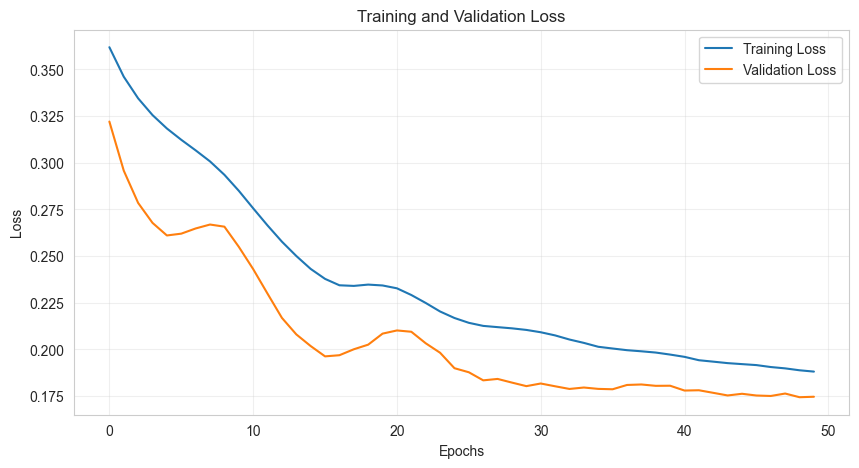

Evaluating model for fold 1...

Evaluation Metrics:
RMSE: 0.6837
MAE: 0.4130
MAPE: 305.12%
R²: 0.4326
Fold 1 Metrics:
  RMSE: 0.6837
  MAE: 0.4130
  MAPE: 305.12%
  R²: 0.4326
Adjusted learning rate for next fold: 0.000900

Processing fold 2 (Train: 2023-08-07 to 2024-01-11, Val: 2024-01-12 to 2024-01-18)...
Training data: 947179 samples for 6291 listings
Validation data: 11011 samples for 1573 listings
Building spatial graph connecting 11011 test listings to 10 nearest training listings each...
Created combined graph with 958190 nodes and 220220 edges
Train nodes: 947179, Val nodes: 11011
Training fold 2 using the progressive model from previous folds
Epoch [1/50], Train Loss: 0.1865, Val Loss: 0.1711
Epoch [11/50], Train Loss: 0.1797, Val Loss: 0.1636
Epoch [21/50], Train Loss: 0.1747, Val Loss: 0.1623
Epoch [31/50], Train Loss: 0.1699, Val Loss: 0.1593
Epoch [41/50], Train Loss: 0.1659, Val Loss: 0.1607
Epoch [50/50], Train Loss: 0.1627, Val Loss: 0.1561


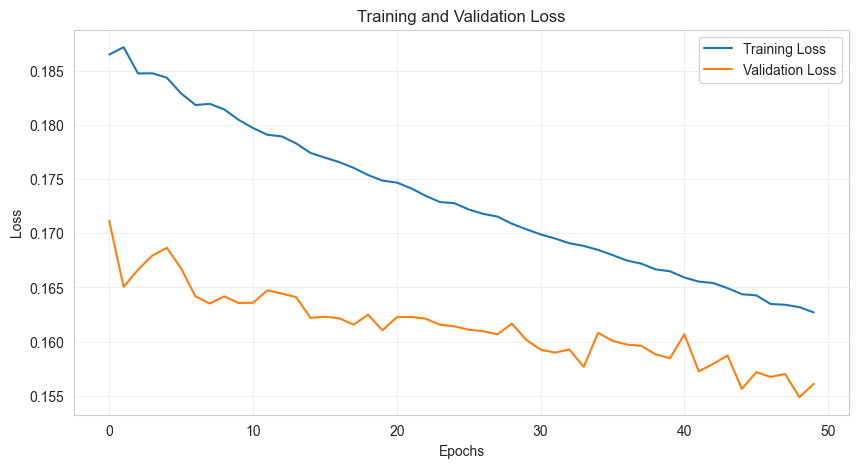

Evaluating model for fold 2...

Evaluation Metrics:
RMSE: 0.6562
MAE: 0.3840
MAPE: 236.32%
R²: 0.4518
Fold 2 Metrics:
  RMSE: 0.6562
  MAE: 0.3840
  MAPE: 236.32%
  R²: 0.4518
Adjusted learning rate for next fold: 0.000810

Processing fold 3 (Train: 2023-08-07 to 2024-01-18, Val: 2024-01-19 to 2024-01-25)...
Training data: 991216 samples for 6291 listings
Validation data: 11011 samples for 1573 listings
Building spatial graph connecting 11011 test listings to 10 nearest training listings each...
Created combined graph with 1002227 nodes and 220220 edges
Train nodes: 991216, Val nodes: 11011
Training fold 3 using the progressive model from previous folds
Epoch [1/50], Train Loss: 0.1617, Val Loss: 0.1587
Epoch [11/50], Train Loss: 0.1610, Val Loss: 0.1581


KeyboardInterrupt: 

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    mean_squared_error, 
    mean_absolute_error, 
    mean_absolute_percentage_error, 
    r2_score
)
import torch_geometric
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv
from sklearn.neighbors import NearestNeighbors
from datetime import timedelta
import os

import warnings
warnings.filterwarnings('ignore')  # This will suppress all warnings

def get_device():
    """
    Select available device (GPU or CPU)
    """
    if torch.cuda.is_available():
        print(f"CUDA is available. Using GPU '{torch.cuda.get_device_name(0)}'")
        return torch.device("cuda")
    else:
        print("No CUDA available. Using CPU.")
        return torch.device("cpu")

def build_spatial_graph(train_data, test_data, k=10):
    """
    Build a graph connecting each test listing to k nearest train listings
    
    Returns:
        edge_index: Tensor of shape [2, num_edges] containing node indices for each edge
        edge_attr: Tensor of shape [num_edges, 1] containing edge weights (inverse distance)
    """
    # Extract coordinates
    train_coords = train_data[['latitude', 'longitude']].values
    test_coords = test_data[['latitude', 'longitude']].values
    
    print(f"Building spatial graph connecting {len(test_coords)} test listings to {k} nearest training listings each...")
    
    # Find k nearest neighbors for each test listing
    nn = NearestNeighbors(n_neighbors=min(k, len(train_coords)))
    nn.fit(train_coords)
    distances, indices = nn.kneighbors(test_coords)
    
    # Create edge indices and attributes
    edge_index = []
    edge_attr = []
    
    for test_idx, (neighbor_indices, neighbor_distances) in enumerate(zip(indices, distances)):
        for train_idx, distance in zip(neighbor_indices, neighbor_distances):
            # Add edge from test listing to train listing
            edge_index.append([test_idx + len(train_data), train_idx])
            edge_attr.append([1.0 / (distance + 1e-6)])  # Weight inversely proportional to distance
            
            # Add reverse edge
            edge_index.append([train_idx, test_idx + len(train_data)])
            edge_attr.append([1.0 / (distance + 1e-6)])
    
    # Add edges between training listings (optional, can help propagate information)
    if len(train_coords) <= 5000:  # Only for smaller datasets to avoid memory issues
        train_nn = NearestNeighbors(n_neighbors=min(5, len(train_coords) - 1))
        train_nn.fit(train_coords)
        train_distances, train_indices = train_nn.kneighbors(train_coords)
        
        for train_idx, (neighbor_indices, neighbor_distances) in enumerate(zip(train_indices, train_distances)):
            for neighbor_idx, distance in zip(neighbor_indices, neighbor_distances):
                if train_idx != neighbor_idx:  # Skip self-loops
                    edge_index.append([train_idx, neighbor_idx])
                    edge_attr.append([1.0 / (distance + 1e-6)])
    
    # Convert to tensors with explicit dtype
    edge_index_tensor = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    edge_attr_tensor = torch.tensor(edge_attr, dtype=torch.float32)
    
    return edge_index_tensor, edge_attr_tensor

class SpatioTemporalGNN(nn.Module):
    def __init__(self, 
                 spatial_features_dim,
                 temporal_features_dim,
                 amenity_features_dim,
                 hidden_dim=64,
                 dropout=0.3):
        super(SpatioTemporalGNN, self).__init__()
        
        # GNN layers for spatial relationships
        self.gnn1 = GCNConv(spatial_features_dim, hidden_dim)
        self.gnn2 = GCNConv(hidden_dim, hidden_dim)
        
        # Temporal processing
        self.temporal_layer = nn.Sequential(
            nn.Linear(temporal_features_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        
        # Amenity processing
        self.amenity_layer = nn.Sequential(
            nn.Linear(amenity_features_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        
        # Attention layer for combining features
        self.attention_layer = nn.Sequential(
            nn.Linear(hidden_dim * 3, 3),
            nn.Softmax(dim=1)
        )
        
        # Combination and prediction layers
        self.prediction_layer = nn.Sequential(
            nn.Linear(hidden_dim * 3, hidden_dim * 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, 1)
        )
    
    def forward(self, data):
        # Unpack the PyG data object
        x, edge_index, edge_attr, temporal_x, amenity_x = data.x, data.edge_index, data.edge_attr, data.temporal_x, data.amenity_x
        
        # Ensure edge_attr is the right shape for GCNConv
        edge_weight = edge_attr.view(-1) if edge_attr.dim() > 1 else edge_attr
        
        # Process spatial features with GNN
        spatial_features = F.relu(self.gnn1(x, edge_index, edge_weight))
        spatial_features = F.dropout(spatial_features, p=0.3, training=self.training)
        spatial_features = self.gnn2(spatial_features, edge_index, edge_weight)
        
        # Process temporal features
        temporal_features = self.temporal_layer(temporal_x)
        
        # Process amenity features
        amenity_features = self.amenity_layer(amenity_x)
        
        # Combine features
        combined_features = torch.cat([
            spatial_features, 
            temporal_features, 
            amenity_features
        ], dim=1)
        
        # Final prediction
        price_prediction = self.prediction_layer(combined_features)
        return price_prediction

def prepare_combined_graph(train_data, val_data, spatial_features, temporal_features, 
                          amenity_features, spatial_scaler, temporal_scaler, target_scaler,
                          device, k=10):
    """
    Prepare a combined graph with both train and validation listings
    """
    # Scale features and convert to float32
    X_train_spatial = spatial_scaler.transform(train_data[spatial_features].values).astype(np.float32)
    X_train_temporal = temporal_scaler.transform(train_data[temporal_features].values).astype(np.float32)
    X_train_amenity = train_data[amenity_features].values.astype(np.float32)
    y_train = target_scaler.transform(train_data['price'].values.reshape(-1, 1)).flatten().astype(np.float32)
    
    X_val_spatial = spatial_scaler.transform(val_data[spatial_features].values).astype(np.float32)
    X_val_temporal = temporal_scaler.transform(val_data[temporal_features].values).astype(np.float32)
    X_val_amenity = val_data[amenity_features].values.astype(np.float32)
    y_val = target_scaler.transform(val_data['price'].values.reshape(-1, 1)).flatten().astype(np.float32)
    
    # Combine train and val features (already float32)
    X_combined_spatial = np.vstack([X_train_spatial, X_val_spatial])
    X_combined_temporal = np.vstack([X_train_temporal, X_val_temporal])
    X_combined_amenity = np.vstack([X_train_amenity, X_val_amenity])
    
    # Create combined y with placeholder values for validation
    y_combined = np.zeros(len(X_combined_spatial), dtype=np.float32)
    y_combined[:len(y_train)] = y_train
    
    # Build spatial graph
    edge_index, edge_attr = build_spatial_graph(
        train_data[['latitude', 'longitude']], 
        val_data[['latitude', 'longitude']], 
        k=k
    )
    
    # Create PyG data object with explicit float32 tensors
    data = Data(
        x=torch.FloatTensor(X_combined_spatial).to(device),
        edge_index=edge_index.to(device),
        edge_attr=edge_attr.to(device).float(),  # Ensure float tensor
        temporal_x=torch.FloatTensor(X_combined_temporal).to(device),
        amenity_x=torch.FloatTensor(X_combined_amenity).to(device),
        y=torch.FloatTensor(y_combined.reshape(-1, 1)).to(device),
        train_mask=torch.zeros(len(X_combined_spatial), dtype=torch.bool).to(device),
        val_mask=torch.zeros(len(X_combined_spatial), dtype=torch.bool).to(device),
        val_y=torch.FloatTensor(y_val.reshape(-1, 1)).to(device),
    )
    
    # Set masks after creation
    data.train_mask[:len(X_train_spatial)] = True
    data.val_mask[len(X_train_spatial):] = True
    data.val_indices = torch.nonzero(data.val_mask).squeeze().to(device)
    
    print(f"Created combined graph with {len(X_combined_spatial)} nodes and {edge_index.shape[1]} edges")
    print(f"Train nodes: {data.train_mask.sum().item()}, Val nodes: {data.val_mask.sum().item()}")
    
    return data

def train_gnn_model(model, data, device, epochs=100, learning_rate=0.001, weight_decay=1e-5):
    """
    Train the GNN model using only the training nodes
    """
    model = model.to(device)
    criterion = nn.HuberLoss(delta=1.0)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, verbose=True)
    
    train_losses = []
    val_losses = []
    
    # Training loop
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        
        # Forward pass
        y_pred = model(data)
        
        # Only compute loss on training nodes
        train_loss = criterion(
            y_pred[data.train_mask], 
            data.y[data.train_mask]
        )
        
        # Backward pass
        train_loss.backward()
        optimizer.step()
        
        train_losses.append(train_loss.item())
        
        # Validation
        model.eval()
        with torch.no_grad():
            # Get predictions for validation nodes
            val_pred = y_pred[data.val_mask]
            val_loss = criterion(val_pred, data.val_y)
            val_losses.append(val_loss.item())
            
            scheduler.step(val_loss)
        
        # Print progress periodically
        if epoch % 10 == 0 or epoch == epochs - 1:
            print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss.item():.4f}, Val Loss: {val_loss.item():.4f}')
    
    # Plot training curve
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    return model, {'train_losses': train_losses, 'val_losses': val_losses}

def evaluate_gnn_model(model, data, target_scaler, val_data):
    """
    Evaluate the GNN model on validation nodes and compare with actual prices
    """
    model.eval()
    with torch.no_grad():
        # Get predictions for all nodes
        predictions = model(data)
        
        # Extract predictions for validation nodes
        val_pred = predictions[data.val_mask].cpu().numpy()
        
        # Inverse transform to get predictions in original scale
        val_pred_original = target_scaler.inverse_transform(val_pred)
        
        # Get true values from the validation data
        val_true = val_data['price'].values.reshape(-1, 1)
        
        # Calculate metrics
        mse = mean_squared_error(val_true, val_pred_original)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(val_true, val_pred_original)
        mape = mean_absolute_percentage_error(val_true, val_pred_original) * 100
        r2 = r2_score(val_true, val_pred_original)
        
        metrics = {
            'mse': mse,
            'rmse': rmse,
            'mae': mae,
            'mape': mape,
            'r2': r2,
            'predictions': val_pred_original,
            'true_values': val_true
        }
        
        # Print metrics
        print("\nEvaluation Metrics:")
        print(f"RMSE: {rmse:.4f}")
        print(f"MAE: {mae:.4f}")
        print(f"MAPE: {mape:.2f}%")
        print(f"R²: {r2:.4f}")
        
        return metrics

def run_time_based_gnn_cv(data_path, train_ids_path, test_ids_path, n_folds=5, epochs=100, 
                         learning_rate=0.001, neighbors=10, output_path=None, progressive_learning=True):
    """
    Run time-based cross-validation using the GNN model
    With progressive learning enabled, the model retains knowledge between folds
    """
    print(f"Running GNN-based spatio-temporal model with time-based CV using {n_folds} consecutive validation weeks")
    if progressive_learning:
        print("Progressive learning ENABLED: Model will retain knowledge between folds")
    
    # Select device
    device = get_device()
    
    # Load train and test IDs
    try:
        with open(train_ids_path, 'r') as f:
            train_ids = [int(line.strip()) for line in f.readlines()]
        print(f"Loaded {len(train_ids)} training listing IDs")
        
        with open(test_ids_path, 'r') as f:
            test_ids = [int(line.strip()) for line in f.readlines()]
        print(f"Loaded {len(test_ids)} test listing IDs")
    except Exception as e:
        raise ValueError(f"Error loading train/test IDs: {e}")
    
    # Load data
    print("Loading data...")
    df = pd.read_csv(data_path)
    
    # Convert date column to datetime
    df['date'] = pd.to_datetime(df['date'])
    
    # Sort by date
    df = df.sort_values(['listing_id', 'date'])
    
    # Get the min and max dates in the dataset
    min_date = df['date'].min()
    max_date = df['date'].max()
    
    print(f"Data spans from {min_date.date()} to {max_date.date()}")
    
    # Calculate total dataset duration
    total_days = (max_date - min_date).days + 1
    weeks_available = total_days // 7

    print(f"Total duration: {total_days} days ({weeks_available} weeks)")
    
    # Create consecutive time-based folds using the last n_folds weeks
    folds = []
    
    for i in range(n_folds):
        # Calculate weeks from the end (0 = last week, 1 = second last week, etc.)
        weeks_from_end = n_folds - 1 - i
        
        # Calculate validation start and end dates
        val_start = max_date - timedelta(days=(weeks_from_end + 1) * 7 - 1)
        val_end = max_date - timedelta(days=weeks_from_end * 7)
        
        # Ensure val_start is not before the first day of data
        if val_start < min_date:
            val_start = min_date
        
        # Training period ends just before validation
        train_end = val_start - timedelta(days=1)
        train_start = min_date
        
        folds.append({
            'fold': i + 1,
            'train_start': train_start,
            'train_end': train_end,
            'val_start': val_start,
            'val_end': val_end
        })
    
    print("Time-based CV folds with consecutive validation weeks:")
    for fold_info in folds:
        print(f"Fold {fold_info['fold']}: "
              f"Train {fold_info['train_start'].date()} to {fold_info['train_end'].date()}, "
              f"Validation {fold_info['val_start'].date()} to {fold_info['val_end'].date()}")
    
    # Define features
    spatial_features = ['latitude', 'longitude', 'accommodates', 'bedrooms', 'bathrooms']
    temporal_features = [
        'DTF_day_of_week', 'DTF_month', 'DTF_is_weekend', 
        'DTF_season_sin', 'DTF_season_cos'
    ]
    amenity_features = [
        col for col in df.columns 
        if col.startswith('has_') and col not in ['has_availability']
    ]
    
    # Initialize scalers using ALL historical data to simulate production scenario
    # In a real-world scenario, you'd only use data available up to the current point in time
    initial_data = df[(df['date'] <= folds[0]['train_end']) & (df['listing_id'].isin(train_ids))].copy()
    
    print("Fitting scalers on initial training data...")
    spatial_scaler = StandardScaler().fit(initial_data[spatial_features])
    temporal_scaler = StandardScaler().fit(initial_data[temporal_features])
    target_scaler = StandardScaler().fit(initial_data['price'].values.reshape(-1, 1))
    
    # Initialize model parameters
    model_params = {
        'spatial_features_dim': len(spatial_features),
        'temporal_features_dim': len(temporal_features),
        'amenity_features_dim': len(amenity_features),
        'hidden_dim': 64,
        'dropout': 0.3
    }
    
    # Store results
    all_fold_results = []
    fold_metrics = []
    
    # Initialize model once if using progressive learning
    if progressive_learning:
        # Create a single model instance that will be updated across all folds
        shared_model = SpatioTemporalGNN(**model_params)
        print("Initialized shared model for progressive learning")
    
    # Run CV
    for fold_info in folds:
        fold = fold_info['fold']
        
        print(f"\nProcessing fold {fold} "
              f"(Train: {fold_info['train_start'].date()} to {fold_info['train_end'].date()}, "
              f"Val: {fold_info['val_start'].date()} to {fold_info['val_end'].date()})...")
        
        # Filter by date ranges and listing IDs
        train_data = df[(df['date'] >= fold_info['train_start']) & 
                        (df['date'] <= fold_info['train_end']) & 
                        (df['listing_id'].isin(train_ids))].copy()
        
        val_data = df[(df['date'] >= fold_info['val_start']) & 
                      (df['date'] <= fold_info['val_end']) & 
                      (df['listing_id'].isin(test_ids))].copy()
        
        if len(train_data) == 0 or len(val_data) == 0:
            print(f"Warning: Skipping fold {fold} due to insufficient data")
            continue
            
        # Print dataset sizes
        print(f"Training data: {len(train_data)} samples for {train_data['listing_id'].nunique()} listings")
        print(f"Validation data: {len(val_data)} samples for {val_data['listing_id'].nunique()} listings")
        
        # Prepare combined graph
        combined_data = prepare_combined_graph(
            train_data, val_data, 
            spatial_features, temporal_features, amenity_features,
            spatial_scaler, temporal_scaler, target_scaler,
            device, k=neighbors
        )
        
        # Use the shared model if progressive learning is enabled, otherwise create a new model
        if progressive_learning:
            model = shared_model  # Use the same model instance across folds
            print(f"Training fold {fold} using the progressive model from previous folds")
        else:
            # Initialize new model for this fold
            model = SpatioTemporalGNN(**model_params)
            print(f"Training fold {fold} with a fresh model")
        
        # Train model
        trained_model, training_history = train_gnn_model(
            model, combined_data, device, epochs=epochs, learning_rate=learning_rate
        )
        
        # If progressive learning, update the shared model
        if progressive_learning:
            shared_model = trained_model
        
        # Evaluate model
        print(f"Evaluating model for fold {fold}...")
        metrics = evaluate_gnn_model(trained_model, combined_data, target_scaler, val_data)
        
        # Add fold info to metrics
        metrics['fold'] = fold
        metrics['train_start'] = fold_info['train_start']
        metrics['train_end'] = fold_info['train_end']
        metrics['val_start'] = fold_info['val_start']
        metrics['val_end'] = fold_info['val_end']
        metrics['train_samples'] = len(train_data)
        metrics['val_samples'] = len(val_data)
        metrics['final_train_loss'] = training_history['train_losses'][-1]
        metrics['final_val_loss'] = training_history['val_losses'][-1]
        
        # Store predictions with dates and listing IDs for later analysis
        val_results = val_data[['date', 'listing_id', 'price']].copy()
        val_results['predicted_price'] = metrics['predictions'].flatten()
        val_results['fold'] = fold
        
        # Calculate errors
        val_results['error'] = val_results['price'] - val_results['predicted_price']
        val_results['abs_error'] = np.abs(val_results['error'])
        val_results['pct_error'] = (np.abs(val_results['error']) / np.abs(val_results['price'] + 1e-8)) * 100
        
        # Add to overall results
        all_fold_results.append(val_results)
        fold_metrics.append(metrics)
        
        # Print metrics
        print(f"Fold {fold} Metrics:")
        print(f"  RMSE: {metrics['rmse']:.4f}")
        print(f"  MAE: {metrics['mae']:.4f}")
        print(f"  MAPE: {metrics['mape']:.2f}%")
        print(f"  R²: {metrics['r2']:.4f}")
        
        # If progressive learning, adjust learning rate for next fold (optional)
        if progressive_learning and fold < n_folds:
            learning_rate = learning_rate * 0.9  # Reduce learning rate by 10% each fold
            print(f"Adjusted learning rate for next fold: {learning_rate:.6f}")
    
    # Combine all results
    if not all_fold_results:
        print("Warning: No results to process. Check if data and folds are valid.")
        return None
    
    all_results = pd.concat(all_fold_results, ignore_index=True)
    
    # Calculate overall metrics
    y_true = all_results['price'].values
    y_pred = all_results['predicted_price'].values
    
    overall_metrics = {
        'rmse': np.sqrt(mean_squared_error(y_true, y_pred)),
        'mae': mean_absolute_error(y_true, y_pred),
        'mape': mean_absolute_percentage_error(y_true, y_pred) * 100,
        'r2': r2_score(y_true, y_pred)
    }
    
    print("\nOverall Metrics:")
    print(f"RMSE: {overall_metrics['rmse']:.4f}")
    print(f"MAE: {overall_metrics['mae']:.4f}")
    print(f"MAPE: {overall_metrics['mape']:.2f}%")
    print(f"R²: {overall_metrics['r2']:.4f}")
    
    # Create fold metrics dataframe
    fold_metrics_df = pd.DataFrame([
        {
            'fold': m['fold'],
            'rmse': m['rmse'],
            'mae': m['mae'],
            'mape': m['mape'],
            'r2': m['r2'],
            'train_samples': m['train_samples'],
            'val_samples': m['val_samples'],
            'final_train_loss': m['final_train_loss'],
            'final_val_loss': m.get('final_val_loss', np.nan)
        } for m in fold_metrics
    ])
    
    print("\nPerformance by Fold:")
    print(fold_metrics_df)
    
    # Calculate daily metrics
    all_results['date_only'] = all_results['date'].dt.date
    daily_metrics = []
    
    for date in all_results['date_only'].unique():
        date_data = all_results[all_results['date_only'] == date]
        
        y_true_day = date_data['price'].values
        y_pred_day = date_data['predicted_price'].values
        
        daily_metrics.append({
            'date': date,
            'rmse': np.sqrt(mean_squared_error(y_true_day, y_pred_day)),
            'mae': mean_absolute_error(y_true_day, y_pred_day),
            'mape': mean_absolute_percentage_error(y_true_day, y_pred_day) * 100,
            'r2': r2_score(y_true_day, y_pred_day) if len(set(y_true_day)) > 1 else np.nan,
            'n_samples': len(y_true_day),
            'fold': date_data['fold'].iloc[0]  # Assume all records for a day are in the same fold
        })
    
    daily_metrics_df = pd.DataFrame(daily_metrics)
    
    # Save results if output path provided
    if output_path:
        os.makedirs(os.path.dirname(os.path.abspath(output_path)), exist_ok=True)
        
        # Save prediction results
        all_results.to_csv(output_path, index=False)
        print(f"Results saved to {output_path}")
        
        # Save fold metrics
        metrics_path = output_path.replace('.csv', '_fold_metrics.csv')
        fold_metrics_df.to_csv(metrics_path, index=False)
        print(f"Fold metrics saved to {metrics_path}")
        
        # Save daily metrics
        daily_metrics_path = output_path.replace('.csv', '_daily_metrics.csv')
        daily_metrics_df.to_csv(daily_metrics_path, index=False)
        print(f"Daily metrics saved to {daily_metrics_path}")
    
    # Create evaluation results dictionary
    evaluation_results = {
        'overall_metrics': overall_metrics,
        'fold_metrics': fold_metrics_df,
        'daily_metrics': daily_metrics_df,
        'all_results': all_results
    }
    
    return evaluation_results

def plot_fold_performance(results):
    """
    Plot performance metrics across different folds
    """
    fold_metrics = results['fold_metrics']
    
    metrics_to_plot = ['rmse', 'mae', 'mape', 'r2']
    fig, axes = plt.subplots(len(metrics_to_plot), 1, figsize=(10, 4 * len(metrics_to_plot)))
    
    for i, metric in enumerate(metrics_to_plot):
        ax = axes[i] if len(metrics_to_plot) > 1 else axes
        plt.sca(ax)
        
        # Different color for R² (higher is better)
        if metric == 'r2':
            bars = plt.bar(fold_metrics['fold'], fold_metrics[metric], color='green')
            plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)  # Zero line for R²
        else:
            bars = plt.bar(fold_metrics['fold'], fold_metrics[metric])
        
        plt.title(f'Fold Performance - {metric.upper()}')
        plt.xlabel('Fold')
        plt.ylabel(metric.upper())
        plt.grid(True, alpha=0.3)
        
        # Add value labels on top of each bar
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + (fold_metrics[metric].max() * 0.01),
                   f'{height:.2f}', ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.show()

def plot_time_series_metrics(results):
    """
    Plot metrics over time
    """
    daily_metrics = results['daily_metrics']
    daily_metrics['date'] = pd.to_datetime(daily_metrics['date'])
    daily_metrics = daily_metrics.sort_values('date')
    
    metrics_to_plot = ['rmse', 'mae', 'mape']
    fig, axes = plt.subplots(len(metrics_to_plot), 1, figsize=(12, 10))
    
    for i, metric in enumerate(metrics_to_plot):
        ax = axes[i] if len(metrics_to_plot) > 1 else axes
        
        # Create colormap based on fold
        n_folds = len(daily_metrics['fold'].unique())
        cmap = plt.cm.get_cmap('viridis', n_folds)
        
        for fold, fold_data in daily_metrics.groupby('fold'):
            color = cmap(int(fold)-1)
            ax.plot(
                fold_data['date'], 
                fold_data[metric], 
                marker='o', 
                linestyle='-', 
                label=f'Fold {fold}',
                color=color
            )
        
        ax.set_title(f'Daily {metric.upper()} Over Time')
        ax.set_xlabel('Date')
        ax.set_ylabel(metric.upper())
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # Format x-axis date ticks
        ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d'))
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
    
    plt.tight_layout()
    plt.show()

def plot_actual_vs_predicted(results):
    """
    Plot actual vs predicted values
    """
    all_results = results['all_results']
    
    plt.figure(figsize=(10, 8))
    
    # Sample 5000 points if there are too many
    if len(all_results) > 5000:
        sample = all_results.sample(5000, random_state=42)
    else:
        sample = all_results
    
    # Create scatterplot with different colors for each fold
    n_folds = sample['fold'].nunique()
    cmap = plt.cm.get_cmap('viridis', n_folds)
    
    for fold, fold_data in sample.groupby('fold'):
        plt.scatter(
            fold_data['price'], 
            fold_data['predicted_price'], 
            alpha=0.5,
            label=f'Fold {fold}',
            color=cmap(int(fold)-1)
        )
    
    # Add perfect prediction line
    min_val = min(sample['price'].min(), sample['predicted_price'].min())
    max_val = max(sample['price'].max(), sample['predicted_price'].max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect Prediction')
    
    # Add regression line
    from scipy import stats
    slope, intercept, r_value, p_value, std_err = stats.linregress(
        sample['price'], sample['predicted_price']
    )
    plt.plot(
        [min_val, max_val], 
        [slope * min_val + intercept, slope * max_val + intercept], 
        'k-', alpha=0.7, label='Best Fit Line'
    )
    
    plt.title('Actual vs Predicted Values')
    plt.xlabel('Actual Price')
    plt.ylabel('Predicted Price')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Add R² value
    r2 = results['overall_metrics']['r2']
    plt.annotate(f'R² = {r2:.4f}', xy=(0.05, 0.95), xycoords='axes fraction',
                 bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.8))
    
    plt.tight_layout()
    plt.show()
def plot_error_distribution(results):
   """
   Plot distribution of prediction errors
   """
   all_results = results['all_results']
   
   plt.figure(figsize=(12, 6))
   
   # Histogram of errors
   plt.subplot(1, 2, 1)
   plt.hist(all_results['error'], bins=50, alpha=0.75, color='skyblue')
   plt.axvline(x=0, color='r', linestyle='--')
   plt.title('Distribution of Prediction Errors')
   plt.xlabel('Error (Actual - Predicted)')
   plt.ylabel('Frequency')
   plt.grid(True, alpha=0.3)
   
   # Add mean and std annotations
   mean_error = all_results['error'].mean()
   std_error = all_results['error'].std()
   plt.annotate(f'Mean = {mean_error:.2f}\nStd = {std_error:.2f}', 
                xy=(0.05, 0.95), xycoords='axes fraction',
                bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.8))
   
   # Boxplot of percentage errors by fold
   plt.subplot(1, 2, 2)
   sns.boxplot(x='fold', y='pct_error', data=all_results, palette='viridis')
   plt.title('Percentage Error by Fold')
   plt.xlabel('Fold')
   plt.ylabel('Percentage Error (%)')
   plt.grid(True, alpha=0.3)
   
   plt.tight_layout()
   plt.show()

def plot_error_by_price_range(results):
   """
   Plot error metrics by price range to identify where the model performs best/worst
   """
   all_results = results['all_results']
   
   # Create price bins
   price_bins = pd.qcut(all_results['price'], 5)
   all_results['price_bin'] = price_bins
   
   # Calculate metrics by price bin
   price_bin_metrics = all_results.groupby('price_bin').agg(
       rmse=('error', lambda x: np.sqrt(np.mean(x**2))),
       mae=('abs_error', 'mean'),
       mape=('pct_error', 'mean'),
       count=('listing_id', 'count')
   ).reset_index()
   
   # Plot
   plt.figure(figsize=(12, 8))
   
   metrics_to_plot = ['rmse', 'mae', 'mape']
   for i, metric in enumerate(metrics_to_plot):
       plt.subplot(len(metrics_to_plot), 1, i+1)
       
       bars = plt.bar(
           price_bin_metrics['price_bin'].astype(str), 
           price_bin_metrics[metric],
           alpha=0.7
       )
       
       plt.title(f'{metric.upper()} by Price Range')
       plt.xlabel('Price Range')
       plt.ylabel(metric.upper())
       plt.xticks(rotation=45)
       plt.grid(True, alpha=0.3)
       
       # Add value labels
       for bar in bars:
           height = bar.get_height()
           plt.text(bar.get_x() + bar.get_width()/2., height + (price_bin_metrics[metric].max() * 0.01),
                  f'{height:.2f}', ha='center', va='bottom', fontsize=9)
   
   plt.tight_layout()
   plt.show()

def run_gnn_analysis(data_path, train_ids_path, test_ids_path, n_folds=5, epochs=50, 
                   learning_rate=0.001, neighbors=10, output_path='results/gnn_results.csv',
                   progressive_learning=True):
    """
    Run a complete GNN-based analysis with time-based CV
    """
    # Create results directory
    os.makedirs('results', exist_ok=True)
    
    # Import seaborn for some plots
    try:
        import seaborn as sns
        sns.set_style('whitegrid')
    except ImportError:
        print("Warning: seaborn not installed. Some plots may look different.")
    
    # Run the cross-validation
    results = run_time_based_gnn_cv(
        data_path=data_path,
        train_ids_path=train_ids_path,
        test_ids_path=test_ids_path,
        n_folds=n_folds,
        epochs=epochs,
        learning_rate=learning_rate,
        neighbors=neighbors,
        output_path=output_path,
        progressive_learning=progressive_learning
    )
    
    if results is None:
        print("Analysis failed. Check error messages above.")

def analyze_neighborhood_influence(results, data_path, train_ids_path, test_ids_path, neighbors_range=[5, 10, 15, 20]):
   """
   Analyze how the number of neighbors affects model performance
   """
   performance_metrics = []
   
   for k in neighbors_range:
       print(f"\n===== Testing with {k} neighbors =====")
       
       # Run analysis with specific k neighbors
       result = run_time_based_gnn_cv(
           data_path=data_path,
           train_ids_path=train_ids_path,
           test_ids_path=test_ids_path,
           n_folds=2,  # Use fewer folds for quicker analysis
           epochs=30,  # Fewer epochs for speed
           neighbors=k,
           output_path=None  # Don't save intermediate results
       )
       
       if result is not None:
           performance_metrics.append({
               'neighbors': k,
               'rmse': result['overall_metrics']['rmse'],
               'mae': result['overall_metrics']['mae'],
               'mape': result['overall_metrics']['mape'],
               'r2': result['overall_metrics']['r2']
           })
   
   # Convert to DataFrame and plot
   metrics_df = pd.DataFrame(performance_metrics)
   
   plt.figure(figsize=(12, 10))
   
   metrics_to_plot = ['rmse', 'mae', 'mape', 'r2']
   for i, metric in enumerate(metrics_to_plot):
       plt.subplot(len(metrics_to_plot), 1, i+1)
       
       plt.plot(metrics_df['neighbors'], metrics_df[metric], 'o-', linewidth=2, markersize=8)
       
       plt.title(f'Effect of Neighbor Count on {metric.upper()}')
       plt.xlabel('Number of Neighbors')
       plt.ylabel(metric.upper())
       plt.grid(True, alpha=0.3)
       
       # Add value labels
       for x, y in zip(metrics_df['neighbors'], metrics_df[metric]):
           plt.text(x, y + (metrics_df[metric].max() * 0.01), f'{y:.4f}', 
                   ha='center', va='bottom', fontsize=9)
   
   plt.tight_layout()
   plt.show()
   
   print("\nOptimal number of neighbors based on metrics:")
   best_rmse = metrics_df.loc[metrics_df['rmse'].idxmin()]
   best_r2 = metrics_df.loc[metrics_df['r2'].idxmax()]
   
   print(f"For lowest RMSE: {best_rmse['neighbors']} neighbors (RMSE = {best_rmse['rmse']:.4f})")
   print(f"For highest R²: {best_r2['neighbors']} neighbors (R² = {best_r2['r2']:.4f})")
   
   return metrics_df

# Main execution
if __name__ == "__main__":
   # File paths
   data_path = r"C:\Users\matth\OneDrive\Documents\KU Leuven\Thesis\De Ultieme Data\top_price_changers_subset\temporal_features_combined.csv"  
   train_ids_path = r"C:\Users\matth\OneDrive\Documents\KU Leuven\Thesis\Github Repository\Airbnb-spatiotemporal\Topic 2\train_ids.txt"
   test_ids_path = r"C:\Users\matth\OneDrive\Documents\KU Leuven\Thesis\Github Repository\Airbnb-spatiotemporal\Topic 2\test_ids.txt"
    
   
   # Run the analysis
results = run_gnn_analysis(
    data_path=data_path,
    train_ids_path=train_ids_path,
    test_ids_path=test_ids_path,
    n_folds=5,  # Use 5 consecutive weeks for validation
    epochs=50,  # Reduce epochs for faster training
    learning_rate=0.001,
    neighbors=10,  # Connect each test listing to 10 nearest training listings
    progressive_learning=True  # Enable progressive learning
)
    


### enhanced gcn architecture

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    mean_squared_error, 
    mean_absolute_error, 
    mean_absolute_percentage_error, 
    r2_score
)
import torch_geometric
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, GATv2Conv
from sklearn.neighbors import NearestNeighbors
from datetime import timedelta, datetime
import os
import seaborn as sns
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')  # This will suppress all warnings

def get_device():
    """
    Select available device (GPU or CPU)
    """
    if torch.cuda.is_available():
        print(f"CUDA is available. Using GPU '{torch.cuda.get_device_name(0)}'")
        return torch.device("cuda")
    else:
        print("No CUDA available. Using CPU.")
        return torch.device("cpu")

def enhance_temporal_features(df):
    """Add more sophisticated temporal features to the dataframe"""
    # Ensure date is datetime
    df['date'] = pd.to_datetime(df['date'])
    
    # Add cyclical encoding for day of week
    df['day_sin'] = np.sin(2 * np.pi * df['date'].dt.dayofweek / 7)
    df['day_cos'] = np.cos(2 * np.pi * df['date'].dt.dayofweek / 7)
    
    # Add weekend flag if not present
    if 'DTF_is_weekend' not in df.columns:
        df['DTF_is_weekend'] = df['date'].dt.dayofweek.isin([5, 6]).astype(int)
    
    # Add cyclical encoding for month
    df['month_sin'] = np.sin(2 * np.pi * df['date'].dt.month / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['date'].dt.month / 12)
    
    # Add holiday proximity feature
    # Common holidays across Europe
    holidays = [
        # 2023
        '2023-01-01', '2023-04-07', '2023-04-09', '2023-05-01', '2023-12-25', '2023-12-31',
        # 2024
        '2024-01-01', '2024-03-29', '2024-03-31', '2024-05-01', '2024-12-25', '2024-12-31'
    ]
    holidays = pd.to_datetime(holidays)
    
    # Calculate days to closest holiday (forward and backward)
    df['days_to_holiday'] = df['date'].apply(
        lambda x: min([abs((x - holiday).days) for holiday in holidays])
    )
    df['holiday_proximity'] = np.exp(-df['days_to_holiday'] / 7)  # Exponential decay
    
    # Add weeks to next month
    df['day_of_month'] = df['date'].dt.day
    df['days_in_month'] = df['date'].dt.days_in_month
    df['days_left_in_month'] = df['days_in_month'] - df['day_of_month']
    df['pct_through_month'] = df['day_of_month'] / df['days_in_month']
    
    # Add seasonality features
    if 'DTF_season_sin' not in df.columns or 'DTF_season_cos' not in df.columns:
        # Day of year normalized to [0, 1]
        day_of_year = df['date'].dt.dayofyear
        # Adjust for leap years
        day_of_year_norm = day_of_year / (366 if df['date'].dt.is_leap_year.any() else 365)
        # Convert to sin/cos
        df['DTF_season_sin'] = np.sin(2 * np.pi * day_of_year_norm)
        df['DTF_season_cos'] = np.cos(2 * np.pi * day_of_year_norm)
    
    # Add price momentum features (if available)
    if 'price_lag_7d' in df.columns:
        df['price_momentum_7d'] = df['price'] - df['price_lag_7d']
    if 'price_lag_1d' in df.columns and 'price_lag_7d' in df.columns:
        df['price_acceleration'] = (df['price_lag_1d'] - df['price_lag_7d']) / 6  # Average daily change
    
    # Add booking window features
    if 'rolling_mean_7d' in df.columns:
        df['price_vs_week_avg'] = df['price'] / (df['rolling_mean_7d'] + 1e-8) - 1  # % difference from week average
    
    # Drop intermediate columns
    df = df.drop(['days_to_holiday', 'day_of_month', 'days_in_month', 'days_left_in_month'], axis=1, errors='ignore')
    
    return df

def build_enhanced_spatial_graph(train_data, test_data, k=10, feature_weight=0.3):
    """
    Build a graph with edge weights based on both geographic and feature similarity
    """
    # Extract coordinates
    train_coords = train_data[['latitude', 'longitude']].values
    test_coords = test_data[['latitude', 'longitude']].values
    
    print(f"Building enhanced spatial graph with {len(test_coords)} test listings and {k} nearest neighbors...")
    
    # Extract and normalize key features for similarity calculation
    features = ['accommodates', 'bedrooms', 'bathrooms']
    available_features = [f for f in features if f in train_data.columns]
    
    if available_features:
        scaler = StandardScaler()
        train_features = scaler.fit_transform(train_data[available_features].fillna(0))
        test_features = scaler.transform(test_data[available_features].fillna(0))
    else:
        # Fallback if no features are available
        print("Warning: No property features available for similarity calculation")
        train_features = np.ones((len(train_coords), 1))
        test_features = np.ones((len(test_coords), 1))
    
    # Find k nearest neighbors for each test listing
    nn = NearestNeighbors(n_neighbors=min(k, len(train_coords)))
    nn.fit(train_coords)
    distances, indices = nn.kneighbors(test_coords)
    
    # Create edge indices and attributes
    edge_index = []
    edge_attr = []
    
    for test_idx, (neighbor_indices, neighbor_distances) in enumerate(zip(indices, distances)):
        test_feat = test_features[test_idx]
        
        for train_idx, distance in zip(neighbor_indices, neighbor_distances):
            # Calculate feature similarity (cosine similarity)
            train_feat = train_features[train_idx]
            feat_norm_product = np.linalg.norm(test_feat) * np.linalg.norm(train_feat)
            
            if feat_norm_product > 1e-8:  # Avoid division by zero
                feat_sim = np.dot(test_feat, train_feat) / feat_norm_product
            else:
                feat_sim = 0.0
            
            # Normalize distance for better numerical stability
            geo_weight = 1.0 / (distance + 1e-6)
            
            # Combined weight: (1-α) * geo_weight + α * feature_weight
            combined_weight = (1 - feature_weight) * geo_weight + feature_weight * max(0, feat_sim)
            
            # Add edge from test listing to train listing
            edge_index.append([test_idx + len(train_data), train_idx])
            edge_attr.append([combined_weight])
            
            # Add reverse edge
            edge_index.append([train_idx, test_idx + len(train_data)])
            edge_attr.append([combined_weight])
    
    # Add edges between training listings (optional, can help propagate information)
    if len(train_coords) <= 5000:  # Only for smaller datasets to avoid memory issues
        train_nn = NearestNeighbors(n_neighbors=min(5, len(train_coords) - 1))
        train_nn.fit(train_coords)
        train_distances, train_indices = train_nn.kneighbors(train_coords)
        
        for train_idx, (neighbor_indices, neighbor_distances) in enumerate(zip(train_indices, train_distances)):
            for neighbor_idx, distance in zip(neighbor_indices, neighbor_distances):
                if train_idx != neighbor_idx:  # Skip self-loops
                    # Calculate feature similarity
                    train_feat_i = train_features[train_idx]
                    train_feat_j = train_features[neighbor_idx]
                    
                    feat_norm_product = np.linalg.norm(train_feat_i) * np.linalg.norm(train_feat_j)
                    if feat_norm_product > 1e-8:
                        feat_sim = np.dot(train_feat_i, train_feat_j) / feat_norm_product
                    else:
                        feat_sim = 0.0
                    
                    geo_weight = 1.0 / (distance + 1e-6)
                    combined_weight = (1 - feature_weight) * geo_weight + feature_weight * max(0, feat_sim)
                    
                    edge_index.append([train_idx, neighbor_idx])
                    edge_attr.append([combined_weight])
    
    # Convert to tensors with explicit dtype
    edge_index_tensor = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    edge_attr_tensor = torch.tensor(edge_attr, dtype=torch.float32)
    
    print(f"Created graph with {edge_index_tensor.shape[1]} edges")
    
    return edge_index_tensor, edge_attr_tensor

class EnhancedSpatioTemporalGNN(nn.Module):
    def __init__(self, 
                 spatial_features_dim,
                 temporal_features_dim,
                 amenity_features_dim,
                 hidden_dim=64,
                 dropout=0.3,
                 heads=4,
                 edge_dim=1):
        super(EnhancedSpatioTemporalGNN, self).__init__()
        
        # For multi-head attention, ensure hidden_dim is divisible by heads
        self.h_dim = hidden_dim
        self.heads = heads
        self.head_dim = hidden_dim // heads
        
        # Important: Make sure the output dimension is consistent
        gat_out_dim = self.head_dim * heads  # This ensures exact dimensions
        
        # Replace GCN with GAT for better spatial relationship modeling
        self.gat1 = GATv2Conv(spatial_features_dim, self.head_dim, heads=heads, edge_dim=edge_dim)
        self.gat2 = GATv2Conv(gat_out_dim, self.head_dim, heads=heads, edge_dim=edge_dim)
        
        # Add batch normalization for more stable training - USING EXACT OUTPUT DIMENSIONS
        self.bn1 = nn.BatchNorm1d(gat_out_dim)
        self.bn2 = nn.BatchNorm1d(gat_out_dim)
        
        # Enhanced temporal processing
        self.temporal_layer1 = nn.Linear(temporal_features_dim, hidden_dim)
        self.temporal_bn1 = nn.BatchNorm1d(hidden_dim)
        self.temporal_layer2 = nn.Linear(hidden_dim, hidden_dim)
        self.temporal_bn2 = nn.BatchNorm1d(hidden_dim)
        
        # Enhanced amenity processing with residual connection
        self.amenity_layer1 = nn.Linear(amenity_features_dim, hidden_dim)
        self.amenity_bn1 = nn.BatchNorm1d(hidden_dim)
        self.amenity_layer2 = nn.Linear(hidden_dim, hidden_dim)
        self.amenity_bn2 = nn.BatchNorm1d(hidden_dim)
        
        # Feature fusion mechanism
        self.fusion_weights = nn.Parameter(torch.ones(3, hidden_dim))
        self.fusion_bias = nn.Parameter(torch.zeros(hidden_dim))
        
        # Final prediction layers with residual connections
        self.fc1 = nn.Linear(hidden_dim, hidden_dim * 2)
        self.fc1_bn = nn.BatchNorm1d(hidden_dim * 2)
        self.fc2 = nn.Linear(hidden_dim * 2, hidden_dim)
        self.fc2_bn = nn.BatchNorm1d(hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, 1)
        
        self.dropout = nn.Dropout(dropout)
        self.dropout_heavy = nn.Dropout(dropout + 0.1)
        
        # Optional dimension adjustment if needed
        self.dim_adjust = None
        if gat_out_dim != hidden_dim:
            self.dim_adjust = nn.Linear(gat_out_dim, hidden_dim)
    
    def forward(self, data):
        # Unpack the PyG data object
        x, edge_index, edge_attr, temporal_x, amenity_x = data.x, data.edge_index, data.edge_attr, data.temporal_x, data.amenity_x
        
        # First GAT layer with batch normalization and residual
        spatial_features = self.gat1(x, edge_index, edge_attr=edge_attr)
        spatial_features = F.elu(spatial_features)
        spatial_features = self.bn1(spatial_features)
        spatial_features = self.dropout(spatial_features)
        
        # Second GAT layer
        spatial_features_res = spatial_features
        spatial_features = self.gat2(spatial_features, edge_index, edge_attr=edge_attr)
        spatial_features = self.bn2(spatial_features)
        
        # Add residual connection if dimensions match
        if spatial_features.shape == spatial_features_res.shape:
            spatial_features = spatial_features + spatial_features_res
        
        # Apply dimension adjustment if needed
        if self.dim_adjust is not None:
            spatial_features = self.dim_adjust(spatial_features)
        
        # Process temporal features with enhanced layers
        temporal_features = F.elu(self.temporal_layer1(temporal_x))
        temporal_features = self.temporal_bn1(temporal_features)
        temporal_features = self.dropout(temporal_features)
        temporal_features_res = temporal_features
        temporal_features = F.elu(self.temporal_layer2(temporal_features))
        temporal_features = self.temporal_bn2(temporal_features)
        temporal_features = temporal_features + temporal_features_res  # Residual connection
        
        # Process amenity features with residual connection
        amenity_features = F.elu(self.amenity_layer1(amenity_x))
        amenity_features = self.amenity_bn1(amenity_features)
        amenity_features = self.dropout(amenity_features)
        amenity_features_res = amenity_features
        amenity_features = F.elu(self.amenity_layer2(amenity_features))
        amenity_features = self.amenity_bn2(amenity_features)
        amenity_features = amenity_features + amenity_features_res  # Residual connection
        
        # Dynamic feature fusion with learned weights
        normalized_weights = F.softmax(self.fusion_weights, dim=0)
        
        # Apply weights to each feature type
        fused_features = (
            spatial_features * normalized_weights[0] +
            temporal_features * normalized_weights[1] +
            amenity_features * normalized_weights[2] +
            self.fusion_bias
        )
        
        # Final prediction with residual connections
        out = F.elu(self.fc1(fused_features))
        out = self.fc1_bn(out)
        out = self.dropout(out)
        
        out = F.elu(self.fc2(out))
        out = self.fc2_bn(out)
        out = self.dropout_heavy(out)
        
        price_prediction = self.fc3(out)
        
        return price_prediction

def prepare_enhanced_graph(train_data, val_data, spatial_features, temporal_features, 
                          amenity_features, spatial_scaler, temporal_scaler, target_scaler,
                          device, k=10, feature_weight=0.3):
    """
    Prepare a combined graph with both train and validation listings using enhanced features
    """
    # Scale features and convert to float32
    X_train_spatial = spatial_scaler.transform(train_data[spatial_features].values).astype(np.float32)
    X_train_temporal = temporal_scaler.transform(train_data[temporal_features].values).astype(np.float32)
    X_train_amenity = train_data[amenity_features].values.astype(np.float32)
    y_train = target_scaler.transform(train_data['price'].values.reshape(-1, 1)).flatten().astype(np.float32)
    
    X_val_spatial = spatial_scaler.transform(val_data[spatial_features].values).astype(np.float32)
    X_val_temporal = temporal_scaler.transform(val_data[temporal_features].values).astype(np.float32)
    X_val_amenity = val_data[amenity_features].values.astype(np.float32)
    y_val = target_scaler.transform(val_data['price'].values.reshape(-1, 1)).flatten().astype(np.float32)
    
    # Combine train and val features (already float32)
    X_combined_spatial = np.vstack([X_train_spatial, X_val_spatial])
    X_combined_temporal = np.vstack([X_train_temporal, X_val_temporal])
    X_combined_amenity = np.vstack([X_train_amenity, X_val_amenity])
    
    # Create combined y with placeholder values for validation
    y_combined = np.zeros(len(X_combined_spatial), dtype=np.float32)
    y_combined[:len(y_train)] = y_train
    
    # Build enhanced spatial graph with feature similarity
    edge_index, edge_attr = build_enhanced_spatial_graph(
        train_data[['latitude', 'longitude'] + [f for f in ['accommodates', 'bedrooms', 'bathrooms'] if f in train_data.columns]], 
        val_data[['latitude', 'longitude'] + [f for f in ['accommodates', 'bedrooms', 'bathrooms'] if f in val_data.columns]], 
        k=k,
        feature_weight=feature_weight
    )
    
    # Create PyG data object with explicit float32 tensors
    data = Data(
        x=torch.FloatTensor(X_combined_spatial).to(device),
        edge_index=edge_index.to(device),
        edge_attr=edge_attr.to(device),  # Keep edge_attr as is for GATv2Conv
        temporal_x=torch.FloatTensor(X_combined_temporal).to(device),
        amenity_x=torch.FloatTensor(X_combined_amenity).to(device),
        y=torch.FloatTensor(y_combined.reshape(-1, 1)).to(device),
        train_mask=torch.zeros(len(X_combined_spatial), dtype=torch.bool).to(device),
        val_mask=torch.zeros(len(X_combined_spatial), dtype=torch.bool).to(device),
        val_y=torch.FloatTensor(y_val.reshape(-1, 1)).to(device),
    )
    
    # Set masks after creation
    data.train_mask[:len(X_train_spatial)] = True
    data.val_mask[len(X_train_spatial):] = True
    data.val_indices = torch.nonzero(data.val_mask).squeeze().to(device)
    
    print(f"Created enhanced graph with {len(X_combined_spatial)} nodes and {edge_index.shape[1]} edges")
    print(f"Train nodes: {data.train_mask.sum().item()}, Val nodes: {data.val_mask.sum().item()}")
    
    return data

def train_gnn_model_improved(model, data, device, epochs=100, learning_rate=0.001, 
                            weight_decay=1e-5, patience=15, use_progress_bar=True):
    """
    Enhanced training with early stopping and cyclic learning rate
    """
    model = model.to(device)
    criterion = nn.HuberLoss(delta=0.9)  # Slightly adjusted Huber loss
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    
    # Use OneCycleLR scheduler for faster convergence
    scheduler = optim.lr_scheduler.OneCycleLR(
        optimizer, 
        max_lr=learning_rate,
        steps_per_epoch=1, 
        epochs=epochs,
        pct_start=0.3  # Spend 30% of time warming up
    )
    
    # Early stopping setup
    best_val_loss = float('inf')
    best_model_state = None
    patience_counter = 0
    
    train_losses = []
    val_losses = []
    
    # Use tqdm for progress bar if requested
    epoch_iterator = tqdm(range(epochs)) if use_progress_bar else range(epochs)
    
    # Training loop
    for epoch in epoch_iterator:
        model.train()
        optimizer.zero_grad()
        
        # Forward pass
        y_pred = model(data)
        
        # Only compute loss on training nodes
        train_loss = criterion(
            y_pred[data.train_mask], 
            data.y[data.train_mask]
        )
        
        # Add L1 regularization for sparsity
        l1_reg = 0
        for param in model.parameters():
            l1_reg += torch.norm(param, 1)
        
        train_loss = train_loss + 1e-5 * l1_reg
        
        # Backward pass
        train_loss.backward()
        
        # Gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        optimizer.step()
        scheduler.step()
        
        train_losses.append(train_loss.item())
        
        # Validation
        model.eval()
        with torch.no_grad():
            # Get predictions for validation nodes
            val_pred = y_pred[data.val_mask]
            val_loss = criterion(val_pred, data.val_y)
            val_losses.append(val_loss.item())
        
        # Update progress bar if using tqdm
        if use_progress_bar:
            epoch_iterator.set_description(f"Train: {train_loss.item():.4f}, Val: {val_loss.item():.4f}")
        # Print progress periodically if not using progress bar
        elif epoch % 10 == 0 or epoch == epochs - 1:
            print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss.item():.4f}, Val Loss: {val_loss.item():.4f}')
        
        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = {k: v.cpu().detach() for k, v in model.state_dict().items()}
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f'Early stopping at epoch {epoch+1}')
                break
    
    # Load best model
    if best_model_state is not None:
        model.load_state_dict({k: v.to(device) for k, v in best_model_state.items()})
    
    return model, {'train_losses': train_losses, 'val_losses': val_losses}

def evaluate_gnn_model(model, data, target_scaler, val_data):
    """
    Evaluate the GNN model on validation nodes and compare with actual prices
    """
    model.eval()
    with torch.no_grad():
        # Get predictions for all nodes
        predictions = model(data)
        
        # Extract predictions for validation nodes
        val_pred = predictions[data.val_mask].cpu().numpy()
        
        # Inverse transform to get predictions in original scale
        val_pred_original = target_scaler.inverse_transform(val_pred)
        
        # Get true values from the validation data
        val_true = val_data['price'].values.reshape(-1, 1)
        
        # Calculate metrics
        mse = mean_squared_error(val_true, val_pred_original)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(val_true, val_pred_original)
        mape = mean_absolute_percentage_error(val_true, val_pred_original) * 100
        r2 = r2_score(val_true, val_pred_original)
        
        metrics = {
            'mse': mse,
            'rmse': rmse,
            'mae': mae,
            'mape': mape,
            'r2': r2,
            'predictions': val_pred_original,
            'true_values': val_true
        }
        
        # Print metrics
        print("\nEvaluation Metrics:")
        print(f"RMSE: {rmse:.4f}")
        print(f"MAE: {mae:.4f}")
        print(f"MAPE: {mape:.2f}%")
        print(f"R²: {r2:.4f}")
        
        return metrics

def create_and_train_ensemble(train_data, val_data, spatial_features, temporal_features, 
                             amenity_features, spatial_scaler, temporal_scaler, target_scaler,
                             device, n_models=3, epochs=100, base_lr=0.001, k_neighbors=10):
    """
    Create and train an ensemble of models with different initializations
    """
    models = []
    
    for i in range(n_models):
        print(f"\nTraining model {i+1}/{n_models} for ensemble...")
        
        # Create model with slightly different hyperparameters
        model = EnhancedSpatioTemporalGNN(
            spatial_features_dim=len(spatial_features),
            temporal_features_dim=len(temporal_features),
            amenity_features_dim=len(amenity_features),
            hidden_dim=64 + (i * 8),  # Slightly different architectures
            dropout=0.3 - (i * 0.05),
            heads=3 + i,
            edge_dim=1  # Add edge_dim parameter
        )
        
        # Prepare data with different neighbor counts
        data = prepare_enhanced_graph(
            train_data, val_data, 
            spatial_features, temporal_features, amenity_features,
            spatial_scaler, temporal_scaler, target_scaler,
            device, k=k_neighbors + (i * 2),
            feature_weight=0.2 + (i * 0.1)  # Vary feature weight for diversity
        )
        
        # Train model with different learning rates
        trained_model, history = train_gnn_model_improved(
            model, data, device, 
            epochs=epochs,
            learning_rate=base_lr * (1.0 + (i * 0.2)),
            weight_decay=1e-5 * (1.0 + (i * 0.5)),
            patience=15
        )
        
        # Evaluate individual model
        print(f"Evaluating ensemble model {i+1}...")
        metrics = evaluate_gnn_model(trained_model, data, target_scaler, val_data)
        
        # Store model, data, and metrics
        models.append({
            'model': trained_model,
            'data': data,
            'metrics': metrics
        })
    
    return models

def predict_with_ensemble(ensemble, val_data, target_scaler, weights=None):
    """
    Generate predictions using an ensemble of models with optional weighting
    """
    all_predictions = []
    
    # If no weights provided, use equal weighting
    if weights is None:
        weights = [1/len(ensemble)] * len(ensemble)
    else:
        # Normalize weights to sum to 1
        weights = [w / sum(weights) for w in weights]
        
    print(f"Using ensemble with weights: {[round(w, 3) for w in weights]}")
    
    # Get predictions from each model
    for i, model_data in enumerate(ensemble):
        model = model_data['model']
        data = model_data['data']
        
        model.eval()
        with torch.no_grad():
            # Get predictions
            predictions = model(data)
            
            # Extract validation predictions
            val_pred = predictions[data.val_mask].cpu().numpy()
            
            # Store predictions with their weight
            all_predictions.append((val_pred, weights[i]))
    
    # Combine predictions with weights
    weighted_preds = np.zeros_like(all_predictions[0][0])
    for preds, weight in all_predictions:
        weighted_preds += preds * weight
    
    # Transform back to original scale
    final_predictions = target_scaler.inverse_transform(weighted_preds)
    
    # Calculate metrics
    val_true = val_data['price'].values.reshape(-1, 1)
    mse = mean_squared_error(val_true, final_predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(val_true, final_predictions)
    mape = mean_absolute_percentage_error(val_true, final_predictions) * 100
    r2 = r2_score(val_true, final_predictions)
    
    # Print metrics
    print("\nEnsemble Evaluation Metrics:")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"MAPE: {mape:.2f}%")
    print(f"R²: {r2:.4f}")
    
    return {
        'predictions': final_predictions,
        'true_values': val_true,
        'rmse': rmse,
        'mae': mae, 
        'mape': mape,
        'r2': r2
    }

def run_enhanced_gnn_cv(data_path, train_ids_path, test_ids_path, n_folds=5, epochs=100, 
                       learning_rate=0.001, neighbors=10, output_path=None, use_ensemble=True,
                       n_ensemble=3, progressive_learning=True):
    """
    Run time-based cross-validation using the enhanced GNN model
    with optional ensemble and progressive learning
    """
    print(f"Running Enhanced GNN-based spatio-temporal model with time-based CV using {n_folds} consecutive validation weeks")
    
    if progressive_learning:
        print("Progressive learning ENABLED: Model will retain knowledge between folds")
    if use_ensemble:
        print(f"Ensemble learning ENABLED: Using {n_ensemble} models per fold")
    
    # Select device
    device = get_device()
    
    # Load train and test IDs
    try:
        with open(train_ids_path, 'r') as f:
            train_ids = [int(line.strip()) for line in f.readlines()]
        print(f"Loaded {len(train_ids)} training listing IDs")
        
        with open(test_ids_path, 'r') as f:
            test_ids = [int(line.strip()) for line in f.readlines()]
        print(f"Loaded {len(test_ids)} test listing IDs")
    except Exception as e:
        raise ValueError(f"Error loading train/test IDs: {e}")
    
    # Load data
    print("Loading data...")
    df = pd.read_csv(data_path)
    
    # Convert date column to datetime
    df['date'] = pd.to_datetime(df['date'])
    
    # Add enhanced temporal features
    print("Enhancing temporal features...")
    df = enhance_temporal_features(df)
    
    # Sort by date
    df = df.sort_values(['listing_id', 'date'])
    
    # Get the min and max dates in the dataset
    min_date = df['date'].min()
    max_date = df['date'].max()
    
    print(f"Data spans from {min_date.date()} to {max_date.date()}")
    
    # Calculate total dataset duration
    total_days = (max_date - min_date).days + 1
    weeks_available = total_days // 7

    print(f"Total duration: {total_days} days ({weeks_available} weeks)")
    
    # Create consecutive time-based folds using the last n_folds weeks
    folds = []
    
    for i in range(n_folds):
        # Calculate weeks from the end (0 = last week, 1 = second last week, etc.)
        weeks_from_end = n_folds - 1 - i
        
        # Calculate validation start and end dates
        val_start = max_date - timedelta(days=(weeks_from_end + 1) * 7 - 1)
        val_end = max_date - timedelta(days=weeks_from_end * 7)
        
        # Ensure val_start is not before the first day of data
        if val_start < min_date:
            val_start = min_date
        
        # Training period ends just before validation
        train_end = val_start - timedelta(days=1)
        train_start = min_date
        
        folds.append({
            'fold': i + 1,
            'train_start': train_start,
            'train_end': train_end,
            'val_start': val_start,
            'val_end': val_end
        })
    
    print("Time-based CV folds with consecutive validation weeks:")
    for fold_info in folds:
        print(f"Fold {fold_info['fold']}: "
              f"Train {fold_info['train_start'].date()} to {fold_info['train_end'].date()}, "
              f"Validation {fold_info['val_start'].date()} to {fold_info['val_end'].date()}")
    
    # Define features with expanded temporal features
    spatial_features = ['latitude', 'longitude', 'accommodates', 'bedrooms', 'bathrooms']
    
    # Update temporal features to include new ones
    temporal_features = [
        'DTF_day_of_week', 'DTF_month', 'DTF_is_weekend', 
        'DTF_season_sin', 'DTF_season_cos',
        'day_sin', 'day_cos', 'month_sin', 'month_cos',
        'holiday_proximity', 'pct_through_month'
    ]
    
    # Add price momentum features if available
    if 'price_momentum_7d' in df.columns:
        temporal_features.extend(['price_momentum_7d'])
    if 'price_acceleration' in df.columns:
        temporal_features.extend(['price_acceleration'])
    if 'price_vs_week_avg' in df.columns:
        temporal_features.extend(['price_vs_week_avg'])
    
    # Make sure all temporal features exist in the dataframe
    temporal_features = [f for f in temporal_features if f in df.columns]
    
    amenity_features = [
        col for col in df.columns 
        if col.startswith('has_') and col not in ['has_availability']
    ]
    
    # Initialize scalers using ALL historical data to simulate production scenario
    # In a real-world scenario, you'd only use data available up to the current point in time
    initial_data = df[(df['date'] <= folds[0]['train_end']) & (df['listing_id'].isin(train_ids))].copy()
    
    print("Fitting scalers on initial training data...")
    spatial_scaler = StandardScaler().fit(initial_data[spatial_features])
    temporal_scaler = StandardScaler().fit(initial_data[temporal_features])
    target_scaler = StandardScaler().fit(initial_data['price'].values.reshape(-1, 1))
    
    # Initialize model parameters
    model_params = {
        'spatial_features_dim': len(spatial_features),
        'temporal_features_dim': len(temporal_features),
        'amenity_features_dim': len(amenity_features),
        'hidden_dim': 64,
        'dropout': 0.3,
        'heads': 4,
        'edge_dim': 1  # Added edge_dim parameter
    }
    
    # Store results
    all_fold_results = []
    fold_metrics = []
    
    # Initialize model or ensemble once if using progressive learning
    if progressive_learning:
        if use_ensemble:
            # Create ensemble of models that will be updated across folds
            shared_ensemble = [
                EnhancedSpatioTemporalGNN(
                    spatial_features_dim=len(spatial_features),
                    temporal_features_dim=len(temporal_features),
                    amenity_features_dim=len(amenity_features),
                    hidden_dim=64 + (i * 8),
                    dropout=0.3 - (i * 0.05),
                    heads=3 + i,
                    edge_dim=1  # Include edge_dim
                ) for i in range(n_ensemble)
            ]
            print(f"Initialized shared ensemble of {n_ensemble} models for progressive learning")
        else:
            # Create a single model instance that will be updated across all folds
            shared_model = EnhancedSpatioTemporalGNN(**model_params)
            print("Initialized shared model for progressive learning")
    
    # Run CV
    for fold_info in folds:
        fold = fold_info['fold']
        
        print(f"\n{'='*50}")
        print(f"Processing fold {fold} "
              f"(Train: {fold_info['train_start'].date()} to {fold_info['train_end'].date()}, "
              f"Val: {fold_info['val_start'].date()} to {fold_info['val_end'].date()})...")
        print(f"{'='*50}")
        
        # Filter by date ranges and listing IDs
        train_data = df[(df['date'] >= fold_info['train_start']) & 
                        (df['date'] <= fold_info['train_end']) & 
                        (df['listing_id'].isin(train_ids))].copy()
        
        val_data = df[(df['date'] >= fold_info['val_start']) & 
                      (df['date'] <= fold_info['val_end']) & 
                      (df['listing_id'].isin(test_ids))].copy()
        
        if len(train_data) == 0 or len(val_data) == 0:
            print(f"Warning: Skipping fold {fold} due to insufficient data")
            continue
            
        # Print dataset sizes
        print(f"Training data: {len(train_data)} samples for {train_data['listing_id'].nunique()} listings")
        print(f"Validation data: {len(val_data)} samples for {val_data['listing_id'].nunique()} listings")
        
        if use_ensemble:
            # Ensemble approach
            if progressive_learning and fold > 1:
                # Use the previously trained ensemble as starting point
                print(f"Using progressive ensemble from previous fold as starting point")
                
                # Create and train ensemble with different hyperparameters
                ensemble_results = []
                
                for i, base_model in enumerate(shared_ensemble):
                    print(f"\nTraining ensemble model {i+1}/{n_ensemble} for fold {fold}")
                    
                    # Create a copy of the model with the same weights
                    model = EnhancedSpatioTemporalGNN(
                        spatial_features_dim=len(spatial_features),
                        temporal_features_dim=len(temporal_features),
                        amenity_features_dim=len(amenity_features),
                        hidden_dim=64 + (i * 8),  # Varying architecture
                        dropout=0.3 - (i * 0.05),
                        heads=3 + i,
                        edge_dim=1  # Include edge_dim
                    )
                    
                    # Copy weights from base model
                    model.load_state_dict(base_model.state_dict())
                    
                    # Prepare data with different settings for diversity
                    data = prepare_enhanced_graph(
                        train_data, val_data, 
                        spatial_features, temporal_features, amenity_features,
                        spatial_scaler, temporal_scaler, target_scaler,
                        device, k=neighbors + (i * 2),
                        feature_weight=0.2 + (i * 0.1)
                    )
                    
                    # Train with reduced learning rate for fine-tuning
                    trained_model, history = train_gnn_model_improved(
                        model, data, device, 
                        epochs=epochs,
                        learning_rate=learning_rate * (0.8 - (fold-1) * 0.1),  # Reduce LR for later folds
                        weight_decay=1e-5 * (1.0 + (i * 0.2)),
                        patience=15
                    )
                    
                    # Update the base model for next fold
                    shared_ensemble[i] = trained_model
                    
                    # Store model and data
                    ensemble_results.append({
                        'model': trained_model,
                        'data': data
                    })
                
            else:
                # Create a fresh ensemble
                print(f"Creating a fresh ensemble for fold {fold}")
                
                # Create and train ensemble
                ensemble = create_and_train_ensemble(
                    train_data, val_data, 
                    spatial_features, temporal_features, amenity_features,
                    spatial_scaler, temporal_scaler, target_scaler,
                    device, n_models=n_ensemble, epochs=epochs, 
                    base_lr=learning_rate, k_neighbors=neighbors
                )
                
                # Store models for progressive learning if enabled
                if progressive_learning:
                    shared_ensemble = [e['model'] for e in ensemble]
                
                # Extract models and data
                ensemble_results = [{'model': e['model'], 'data': e['data']} for e in ensemble]
            
            # Evaluate ensemble
            # Calculate weights based on validation performance on this fold
            model_metrics = []
            for i, model_data in enumerate(ensemble_results):
                model = model_data['model']
                data = model_data['data']
                
                # Evaluate individual model
                metrics = evaluate_gnn_model(model, data, target_scaler, val_data)
                model_metrics.append((i, metrics['r2']))
            
            # Weight models by their R² value (higher R² = higher weight)
            weights = [max(0.1, m[1]) for m in model_metrics]  # Ensure no negative weights
            
            # Make predictions with weighted ensemble
            metrics = predict_with_ensemble(
                ensemble_results, val_data, target_scaler, weights=weights
            )
            
        else:
            # Single model approach
            # Prepare combined graph
            combined_data = prepare_enhanced_graph(
                train_data, val_data, 
                spatial_features, temporal_features, amenity_features,
                spatial_scaler, temporal_scaler, target_scaler,
                device, k=neighbors
            )
            
            # Use the shared model if progressive learning is enabled, otherwise create a new model
            if progressive_learning and fold > 1:
                model = shared_model  # Use the same model instance across folds
                print(f"Training fold {fold} using the progressive model from previous folds")
                
                # Reduce learning rate for later folds
                current_lr = learning_rate * (0.8 - (fold-1) * 0.1)
                print(f"Using reduced learning rate: {current_lr:.6f}")
                
            else:
                # Initialize new model for this fold
                model = EnhancedSpatioTemporalGNN(**model_params)
                print(f"Training fold {fold} with a fresh model")
                current_lr = learning_rate
            
            # Train model
            trained_model, training_history = train_gnn_model_improved(
                model, combined_data, device, epochs=epochs, learning_rate=current_lr
            )
            
            # If progressive learning, update the shared model
            if progressive_learning:
                shared_model = trained_model
            
            # Evaluate model
            print(f"Evaluating model for fold {fold}...")
            metrics = evaluate_gnn_model(trained_model, combined_data, target_scaler, val_data)
        
        # Add fold info to metrics
        metrics['fold'] = fold
        metrics['train_start'] = fold_info['train_start']
        metrics['train_end'] = fold_info['train_end']
        metrics['val_start'] = fold_info['val_start']
        metrics['val_end'] = fold_info['val_end']
        metrics['train_samples'] = len(train_data)
        metrics['val_samples'] = len(val_data)
        
        # Store predictions with dates and listing IDs for later analysis
        val_results = val_data[['date', 'listing_id', 'price']].copy()
        val_results['predicted_price'] = metrics['predictions'].flatten()
        val_results['fold'] = fold
        
        # Calculate errors
        val_results['error'] = val_results['price'] - val_results['predicted_price']
        val_results['abs_error'] = np.abs(val_results['error'])
        val_results['pct_error'] = (np.abs(val_results['error']) / np.abs(val_results['price'] + 1e-8)) * 100
        
        # Add to overall results
        all_fold_results.append(val_results)
        fold_metrics.append(metrics)
        
        # Print metrics
        print(f"Fold {fold} Metrics:")
        print(f"  RMSE: {metrics['rmse']:.4f}")
        print(f"  MAE: {metrics['mae']:.4f}")
        print(f"  MAPE: {metrics['mape']:.2f}%")
        print(f"  R²: {metrics['r2']:.4f}")
    
    # Combine all results
    if not all_fold_results:
        print("Warning: No results to process. Check if data and folds are valid.")
        return None
    
    all_results = pd.concat(all_fold_results, ignore_index=True)
    
    # Calculate overall metrics
    y_true = all_results['price'].values
    y_pred = all_results['predicted_price'].values
    
    overall_metrics = {
        'rmse': np.sqrt(mean_squared_error(y_true, y_pred)),
        'mae': mean_absolute_error(y_true, y_pred),
        'mape': mean_absolute_percentage_error(y_true, y_pred) * 100,
        'r2': r2_score(y_true, y_pred)
    }
    
    print("\nOverall Metrics:")
    print(f"RMSE: {overall_metrics['rmse']:.4f}")
    print(f"MAE: {overall_metrics['mae']:.4f}")
    print(f"MAPE: {overall_metrics['mape']:.2f}%")
    print(f"R²: {overall_metrics['r2']:.4f}")
    
    # Create fold metrics dataframe
    fold_metrics_df = pd.DataFrame([
        {
            'fold': m['fold'],
            'rmse': m['rmse'],
            'mae': m['mae'],
            'mape': m['mape'],
            'r2': m['r2'],
            'train_samples': m['train_samples'],
            'val_samples': m['val_samples']
        } for m in fold_metrics
    ])
    
    print("\nPerformance by Fold:")
    print(fold_metrics_df)
    
    # Calculate daily metrics
    all_results['date_only'] = all_results['date'].dt.date
    daily_metrics = []
    
    for date in all_results['date_only'].unique():
        date_data = all_results[all_results['date_only'] == date]
        
        y_true_day = date_data['price'].values
        y_pred_day = date_data['predicted_price'].values
        
        daily_metrics.append({
            'date': date,
            'rmse': np.sqrt(mean_squared_error(y_true_day, y_pred_day)),
            'mae': mean_absolute_error(y_true_day, y_pred_day),
            'mape': mean_absolute_percentage_error(y_true_day, y_pred_day) * 100,
            'r2': r2_score(y_true_day, y_pred_day) if len(set(y_true_day)) > 1 else np.nan,
            'n_samples': len(y_true_day),
            'fold': date_data['fold'].iloc[0]  # Assume all records for a day are in the same fold
        })
    
    daily_metrics_df = pd.DataFrame(daily_metrics)
    
    # Save results if output path provided
    if output_path:
        os.makedirs(os.path.dirname(os.path.abspath(output_path)), exist_ok=True)
        
        # Save prediction results
        all_results.to_csv(output_path, index=False)
        print(f"Results saved to {output_path}")
        
        # Save fold metrics
        metrics_path = output_path.replace('.csv', '_fold_metrics.csv')
        fold_metrics_df.to_csv(metrics_path, index=False)
        print(f"Fold metrics saved to {metrics_path}")
        
        # Save daily metrics
        daily_metrics_path = output_path.replace('.csv', '_daily_metrics.csv')
        daily_metrics_df.to_csv(daily_metrics_path, index=False)
        print(f"Daily metrics saved to {daily_metrics_path}")
    
    # Create evaluation results dictionary
    evaluation_results = {
        'overall_metrics': overall_metrics,
        'fold_metrics': fold_metrics_df,
        'daily_metrics': daily_metrics_df,
        'all_results': all_results
    }
    
    return evaluation_results

def plot_fold_performance(results):
    """
    Plot performance metrics across different folds
    """
    fold_metrics = results['fold_metrics']
    
    metrics_to_plot = ['rmse', 'mae', 'mape', 'r2']
    fig, axes = plt.subplots(len(metrics_to_plot), 1, figsize=(10, 4 * len(metrics_to_plot)))
    
    for i, metric in enumerate(metrics_to_plot):
        ax = axes[i] if len(metrics_to_plot) > 1 else axes
        plt.sca(ax)
        
        # Different color for R² (higher is better)
        if metric == 'r2':
            bars = plt.bar(fold_metrics['fold'], fold_metrics[metric], color='green')
            plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)  # Zero line for R²
        else:
            bars = plt.bar(fold_metrics['fold'], fold_metrics[metric])
        
        plt.title(f'Fold Performance - {metric.upper()}')
        plt.xlabel('Fold')
        plt.ylabel(metric.upper())
        plt.grid(True, alpha=0.3)
        
        # Add value labels on top of each bar
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + (fold_metrics[metric].max() * 0.01),
                   f'{height:.2f}', ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.show()

def run_enhanced_gnn_analysis(data_path, train_ids_path, test_ids_path, n_folds=5, epochs=50, 
                            learning_rate=0.001, neighbors=10, output_path='results/enhanced_gnn_results.csv',
                            use_ensemble=True, n_ensemble=3, progressive_learning=True):
    """
    Run a complete enhanced GNN-based analysis with time-based CV
    """
    # Create results directory
    os.makedirs('results', exist_ok=True)
    
    # Import seaborn for some plots
    try:
        import seaborn as sns
        sns.set_style('whitegrid')
    except ImportError:
        print("Warning: seaborn not installed. Some plots may look different.")
    
    # Run the cross-validation
    results = run_enhanced_gnn_cv(
        data_path=data_path,
        train_ids_path=train_ids_path,
        test_ids_path=test_ids_path,
        n_folds=n_folds,
        epochs=epochs,
        learning_rate=learning_rate,
        neighbors=neighbors,
        output_path=output_path,
        use_ensemble=use_ensemble,
        n_ensemble=n_ensemble,
        progressive_learning=progressive_learning
    )
    
    if results is None:
        print("Analysis failed. Check error messages above.")
        return None
    
    print("\nGenerating performance visualizations...")
    
    # Plot fold performance
    plot_fold_performance(results)
    
    # Plot time series metrics
    plt.figure(figsize=(12, 8))
    daily_metrics = results['daily_metrics']
    daily_metrics['date'] = pd.to_datetime(daily_metrics['date'])
    
    plt.subplot(2, 1, 1)
    for fold, data in daily_metrics.groupby('fold'):
        plt.plot(data['date'], data['rmse'], marker='o', label=f'Fold {fold}')
    plt.title('RMSE by Date')
    plt.xlabel('Date')
    plt.ylabel('RMSE')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(2, 1, 2)
    for fold, data in daily_metrics.groupby('fold'):
        plt.plot(data['date'], data['r2'], marker='o', label=f'Fold {fold}')
    plt.title('R² by Date')
    plt.xlabel('Date')
    plt.ylabel('R²')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Plot actual vs predicted
    plt.figure(figsize=(10, 8))
    all_results = results['all_results']
    
    # Sample 5000 points if there are too many
    if len(all_results) > 5000:
        sample = all_results.sample(5000, random_state=42)
    else:
        sample = all_results
    
    # Create scatterplot with different colors for each fold
    for fold, data in sample.groupby('fold'):
        plt.scatter(data['price'], data['predicted_price'], alpha=0.5, label=f'Fold {fold}')
    
    # Add perfect prediction line
    lims = [
        min(sample['price'].min(), sample['predicted_price'].min()),
        max(sample['price'].max(), sample['predicted_price'].max())
    ]
    plt.plot(lims, lims, 'r--', label='Perfect Prediction')
    
    plt.title('Actual vs Predicted Prices')
    plt.xlabel('Actual Price')
    plt.ylabel('Predicted Price')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Add R² value
    r2 = results['overall_metrics']['r2']
    plt.annotate(f'R² = {r2:.4f}', xy=(0.05, 0.95), xycoords='axes fraction',
                 bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    # Error distribution
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.hist(all_results['error'], bins=50, alpha=0.7)
    plt.axvline(x=0, color='r', linestyle='--')
    plt.title('Error Distribution')
    plt.xlabel('Error (Actual - Predicted)')
    plt.ylabel('Frequency')
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    sns.boxplot(x='fold', y='pct_error', data=all_results)
    plt.title('Percentage Error by Fold')
    plt.xlabel('Fold')
    plt.ylabel('Percentage Error (%)')
    plt.ylim(0, min(100, all_results['pct_error'].quantile(0.95)))  # Limit y-axis to make plot readable
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return results

# Main execution
if __name__ == "__main__":
    # File paths
    data_path = r"C:\Users\matth\OneDrive\Documents\KU Leuven\Thesis\De Ultieme Data\top_price_changers_subset\temporal_features_combined.csv"
    train_ids_path = r"C:\Users\matth\OneDrive\Documents\KU Leuven\Thesis\Github Repository\Airbnb-spatiotemporal\Topic 2\train_ids.txt"
    test_ids_path = r"C:\Users\matth\OneDrive\Documents\KU Leuven\Thesis\Github Repository\Airbnb-spatiotemporal\Topic 2\test_ids.txt"
    
    # Run the enhanced analysis
    results = run_enhanced_gnn_analysis(
        data_path=data_path,
        train_ids_path=train_ids_path,
        test_ids_path=test_ids_path,
        n_folds=5,                         # Use 5 consecutive weeks for validation
        epochs=50,                         # Training epochs per fold
        learning_rate=0.001,               # Base learning rate
        neighbors=10,                      # Number of spatial neighbors
        output_path='results/enhanced_gnn_results.csv',
        use_ensemble=True,                # Use ensemble of models
        n_ensemble=3,                     # Number of models in ensemble
        progressive_learning=True         # Enable progressive learning across folds
    )

Running Enhanced GNN-based spatio-temporal model with time-based CV using 5 consecutive validation weeks
Progressive learning ENABLED: Model will retain knowledge between folds
CUDA is available. Using GPU 'NVIDIA GeForce RTX 3050 4GB Laptop GPU'
Loaded 6291 training listing IDs
Loaded 1573 test listing IDs
Loading data...
Enhancing temporal features...
Data spans from 2023-08-07 to 2024-02-08
Total duration: 186 days (26 weeks)
Time-based CV folds with consecutive validation weeks:
Fold 1: Train 2023-08-07 to 2024-01-04, Validation 2024-01-05 to 2024-01-11
Fold 2: Train 2023-08-07 to 2024-01-11, Validation 2024-01-12 to 2024-01-18
Fold 3: Train 2023-08-07 to 2024-01-18, Validation 2024-01-19 to 2024-01-25
Fold 4: Train 2023-08-07 to 2024-01-25, Validation 2024-01-26 to 2024-02-01
Fold 5: Train 2023-08-07 to 2024-02-01, Validation 2024-02-02 to 2024-02-08
Fitting scalers on initial training data...
Initialized shared model for progressive learning

Processing fold 1 (Train: 2023-08-07 

Train: 0.1800, Val: 0.2295: 100%|██████████| 50/50 [09:21<00:00, 11.23s/it]


Evaluating model for fold 1...

Evaluation Metrics:
RMSE: 0.6127
MAE: 0.3945
MAPE: 338.47%
R²: 0.5443
Fold 1 Metrics:
  RMSE: 0.6127
  MAE: 0.3945
  MAPE: 338.47%
  R²: 0.5443

Processing fold 2 (Train: 2023-08-07 to 2024-01-11, Val: 2024-01-12 to 2024-01-18)...
Training data: 947179 samples for 6291 listings
Validation data: 11011 samples for 1573 listings
Building enhanced spatial graph with 11011 test listings and 10 nearest neighbors...
Created graph with 220220 edges
Created enhanced graph with 958190 nodes and 220220 edges
Train nodes: 947179, Val nodes: 11011
Training fold 2 using the progressive model from previous folds
Using reduced learning rate: 0.000700


Train: 0.1301, Val: 0.1242: 100%|██████████| 50/50 [14:21<00:00, 17.23s/it]


Evaluating model for fold 2...

Evaluation Metrics:
RMSE: 0.4320
MAE: 0.2764
MAPE: 223.96%
R²: 0.7625
Fold 2 Metrics:
  RMSE: 0.4320
  MAE: 0.2764
  MAPE: 223.96%
  R²: 0.7625

Processing fold 3 (Train: 2023-08-07 to 2024-01-18, Val: 2024-01-19 to 2024-01-25)...
Training data: 991216 samples for 6291 listings
Validation data: 11011 samples for 1573 listings
Building enhanced spatial graph with 11011 test listings and 10 nearest neighbors...
Created graph with 220220 edges
Created enhanced graph with 1002227 nodes and 220220 edges
Train nodes: 991216, Val nodes: 11011
Training fold 3 using the progressive model from previous folds
Using reduced learning rate: 0.000600


Train: 0.1081, Val: 0.0998: 100%|██████████| 50/50 [12:05<00:00, 14.51s/it]


Evaluating model for fold 3...

Evaluation Metrics:
RMSE: 0.4141
MAE: 0.2588
MAPE: 221.97%
R²: 0.7853
Fold 3 Metrics:
  RMSE: 0.4141
  MAE: 0.2588
  MAPE: 221.97%
  R²: 0.7853

Processing fold 4 (Train: 2023-08-07 to 2024-01-25, Val: 2024-01-26 to 2024-02-01)...
Training data: 1035253 samples for 6291 listings
Validation data: 11011 samples for 1573 listings
Building enhanced spatial graph with 11011 test listings and 10 nearest neighbors...
Created graph with 220220 edges
Created enhanced graph with 1046264 nodes and 220220 edges
Train nodes: 1035253, Val nodes: 11011
Training fold 4 using the progressive model from previous folds
Using reduced learning rate: 0.000500


Train: 0.0964, Val: 0.0894: 100%|██████████| 50/50 [12:16<00:00, 14.73s/it]


Evaluating model for fold 4...

Evaluation Metrics:
RMSE: 0.4103
MAE: 0.2479
MAPE: 242.64%
R²: 0.7938
Fold 4 Metrics:
  RMSE: 0.4103
  MAE: 0.2479
  MAPE: 242.64%
  R²: 0.7938

Processing fold 5 (Train: 2023-08-07 to 2024-02-01, Val: 2024-02-02 to 2024-02-08)...
Training data: 1079290 samples for 6291 listings
Validation data: 11011 samples for 1573 listings
Building enhanced spatial graph with 11011 test listings and 10 nearest neighbors...
Created graph with 220220 edges
Created enhanced graph with 1090301 nodes and 220220 edges
Train nodes: 1079290, Val nodes: 11011
Training fold 5 using the progressive model from previous folds
Using reduced learning rate: 0.000400


  0%|          | 0/50 [00:01<?, ?it/s]


RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.
